<h1 style="margin-bottom: 0px;">BooLEVARD: Boolean Logical Evaluation of Activation and Repression in Directed pathways</h1>
<h5 style="margin-bottom: 2px; margin-top: 0px;">Marco Fariñas<sup>1</sup>, Eirini Tsirvouli<sup>2,3</sup>, John Zobolas<sup>4</sup>, Tero Aittokallio<sup>4,5</sup>, Åsmund Flobak<sup>3,6,7</sup>, Kaisa Lehti<sup>1,8</sup></h5>
<h5 style="margin-top: 3px; margin-bottom: 0px;">doi: </h5>
<p style="font-size:small"> 
    <sup>1</sup>. Department of Biomedical Laboratory Science, Norwegian University of Science and Technology (NTNU), Trondheim, Norway. <br>
    <sup>2</sup>. Department of Biology, Norwegian University of Science and Technology (NTNU), Trondheim, Norway.<br>
    <sup>3</sup>. Department of Clinical and Molecular Medicine, Norwegian University of Science and Technology (NTNU), Trondheim, Norway.<br>
    <sup>4</sup>. Department of Cancer Genomics, Oslo University Hospital (OUH), Oslo, Norway.<br>
    <sup>5</sup>. Institute for Molecular Medicine Finland, University of Helsinki, Helsinki, Finland.<br>
    <sup>6</sup>. The Cancer Clinic, St. Olavs Hospital, Trondheim, Norway.<br>
    <sup>7</sup>. Department of Biotechnology and Nanomedicine, Sintef Industry, Trondheim, Norway.<br>
    <sup>8</sup>. Department of Microbiology, Tumor and Cell Biology, Karolinska Institute (KI), Stockholm, Sweden.<br>
</p>
<h4 style="margin-top: 0px; margin-bottom: 2px; font-size: 1.5em"><b>Figure and Supplementary Figure source code</b></h4>
<h4 style="margin-top: 25px; margin-bottom: 0px;"><b><i>Outline</i></b></h4>
<h6 style="margin-top: 15px; margin-bottom: 0px; font-size : 1em; line-height: 1.5em">
    <b>0.- Package Load </b><a href="#section-0">[visit]</a><br>
    <b>1.- Functions </b><a href="#section-1">[visit]</a><br>
    <b>2.- Stable state analysis and transduction analysis with BooLEVARD </b><a href="#section-2">[visit]</a><br>
    2.1.- Figure 3: heatmap of local states and path counts <a href="#section-2.1">[visit]</a><br>
    <b>3.- Study perturbation effects in signal transduction </b><a href="#section-3">[visit]</a><br>
    3.1.- Figure 4: phenotype ranges across perturbations <a href="#section-3.1">[visit]</a><br>
    3.2.- Figure 5: Invasion-Apoptosis resistance <a href="#section-3.2">[visit]</a><br>
    <b>4.- Supplementary Figures </b><a href="#section-4">[visit]</a><br>
    4.1.- Supplementary Figure S1: BooLEVARD's performance <a href="#section-4.1">[visit]</a><br>
    4.2.- Perturbation stable state analysis <a href="#section-4.2">[visit]</a><br>
    <i>4.2.1- Supplementary Figure S2: Perturbation stable state analysis (filtered) </i><a href="#section-4.2.1">[visit]</a><br>
    <i>4.2.2- Supplementary Figure S3: Perturbation stable state analysis (all) </i><a href="#section-4.2.2">[visit]</a><br>
    4.3.- Supplementary Figure S4: Path counts impacting phenotypes across stable states <a href="#section-4.3">[visit]</a><br>
    4.4.- Supplementary Figure S5: Perturbation-induced transitions <a href="#section-4.4">[visit]</a><br><br> 
</h6>

<h4 style="margin-top: 0px; margin-bottom: 2px;" id="section-0"><b>0.- Package load</b></h4>

In [1]:
import time
import sys, io
import boolevard as blv
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyComplexHeatmap import * 
from adjustText import adjust_text
from scipy.stats import spearmanr
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

/home/marco/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


/home/marco/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


<h4 style="margin-top: 0px; margin-bottom: 2px;" id="section-1"><b>1.- Functions</b></h4>

In [2]:
# Min-max scalation, centering option:
def sc_custom(x, ref):
    return (x - ref)/(x.max() - x.min())

# Plot range of path counts leading to the local state of a given node across all perts
def plotrange(data, state, col, sizex, sizey, title):
    if state == "up": filtered_data = data.loc[data[col] > 0, :]
    else: filtered_data = data.loc[data[col] < 0, :]
    filtered_data[f"{col}_sc"] = sc_custom(abs(filtered_data[col]), abs(filtered_data[col]).min())
    if state == "up": filtered_data = filtered_data.reset_index(names = "ID").sort_values(by = [f"{col}_sc", "ID"], ascending = [True, True])
    else: filtered_data = filtered_data.reset_index(names = "ID").sort_values(by = [f"{col}_sc", "ID"], ascending = [True, True])
    filtered_data.index = filtered_data.loc[:, "ID"]
    fig, ax = plt.subplots(figsize = (sizex, sizey))
    bplot = ax.bar(range(len(filtered_data.index)), filtered_data[f"{col}_sc"], color = "black", width = 1.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, filtered_data[f"{col}_sc"].max())
    ax.set_xlim(-0.5, len(filtered_data.index) - 0.5)
    ax.set_xticks([])
    ax.set_title(title, fontweight = "bold", fontsize = 10)
    ax.set_ylabel("Path count (scaled)")
    ax.set_xlabel("Stable States")
    return bplot

# Check path counts leading to the local state of a given node across all perts
def StudyStrength(data, state, col, sizex, sizey, title, save = False, ax = None):
    def custom_color(index, state):
        if index.rsplit("_", 1)[0] == "Unperturbed":
            return "gray"
        else:
            return "#FC766AFF" if state == "up" else "#5B84B1FF"
    if state == "up": filtered_data = data.loc[data[col] > 0, :]
    else: filtered_data = data.loc[data[col] < 0, :]
    filtered_data[f"{col}_sc"] = sc_custom(abs(filtered_data[col]), abs(filtered_data[col]).min())
    if state == "up": filtered_data = filtered_data.reset_index(names = "ID").sort_values(by = [f"{col}_sc", "ID"], ascending = [True, True])
    else: filtered_data = filtered_data.reset_index(names = "ID").sort_values(by = [f"{col}_sc", "ID"], ascending = [False, False])
    filtered_data.index = filtered_data.loc[:, "ID"]
    colors = [custom_color(index, state) for index in filtered_data.index]
    if ax is None:
        fig, ax = plt.subplots(figsize = (sizex, sizey))
    bplot = sb.barplot(x = filtered_data.index, y = f"{col}_sc", data = filtered_data, palette = colors, ax = ax)
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1)
    ax.set_facecolor("white")
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    ax.set_ylim(0, 1.5)
    ax.set_title(title, fontweight = "bold", fontsize = 15)
    ax.set_xlabel("")
    ax.set_ylabel("Path count (scaled)", fontsize = 15)
    ax.tick_params(axis='x', labelsize=12)
    for i, bar in enumerate(bplot.patches):
        value = round(filtered_data[col].iloc[i]/1000, 3)
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03, f'{value}', ha = "center", va = "bottom", fontsize = 11, rotation = 90)
    if save: plt.savefig(save)
    return ax

# Same as StudyStrength but pert-wise
def SSbars(data, cols, sizex, sizey, labs):
    def custom_color(score):
        return "#FC766A" if score > 0 else "#5B84B1"
    processed_data = data.copy()
    for col in cols:
        processed_data[f"{col}_sc"] = sc_custom(processed_data[col], 0)
    processed_data = processed_data.reset_index(names = "ID")
    x_labels = list(processed_data["ID"]) + list(processed_data["ID"])
    values = list(processed_data[f"{cols[0]}_sc"]) + list(processed_data[f"{cols[1]}_sc"])
    colors = [custom_color(v) for v in values]
    x_positions = list(range(len(processed_data))) + list(range(len(processed_data), 2*len(processed_data)))
    y_min = min(values)*1.25
    y_max = max(values)*2.25
    fig, ax = plt.subplots(figsize = (sizex, sizey))
    ax.bar(x_positions, values, color = colors)
    ax.set_xticks(x_positions)
    ax.set_xticklabels([label.rsplit("_", 1)[-1] for label in x_labels], rotation = 0)
    ax.set_ylim(y_min, y_max)
    ax.set_title(processed_data["ID"][0].rsplit("_", 1)[0], fontweight = "bold", fontsize = 10)
    ax.set_ylabel("Path count (scaled)")
    ax.set_xlabel("Stable States")
    y_annot = max(values) * 1.6 
    line_y = max(values) * 1.4 
    ax.text((len(processed_data)-1)/2, y_annot, labs[0], ha="center", fontsize=9)
    ax.text((len(processed_data) * 1.5) - 0.5, y_annot, labs[1], ha="center", fontsize=9)
    ax.hlines(y=line_y, xmin=0, xmax=len(processed_data) - 1, color="black", linewidth=0.5)
    ax.hlines(y=line_y, xmin=len(processed_data), xmax=(len(processed_data)*2) - 1, color="black", linewidth=0.5)
    return ax

# Plot scatter plot with custom labels
def scatter_plot_custom(data, x, y, labelx, labely, save = False, labs = None):
    fig, ax = plt.subplots(figsize = (7,7))
    ax = sb.scatterplot(data = data, x = x, y = y, color = "black", size = 0.5)
    ax.set_xlabel(labelx); ax.set_ylabel(labely); ax.legend_.set_visible(False)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.2)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.2)
    texts = []
    for i in range(data.shape[0]):
        if labs == None:
            texts.append(ax.text(data[x][i], data[y][i], str(data.index[i]), fontsize = 8, color = "black"))
        else:
            points_to_label = labs
            if data.index[i] in points_to_label:
                texts.append(ax.text(data[x][i], data[y][i], str(data.index[i]), fontsize = 8, color = "black"))
    adjust_text(
        texts, 
        only_move = {"points": "xy", "texts": "xy"}, 
        force_text = 5, 
        expand_text = (1.5, 1.5), 
        arrowprops = dict(arrowstyle = "-", color = "gray", lw = 0.5, shrinkA = 5)
    )
    corr, p_value = spearmanr(data[x], data[y])
    print(corr, p_value)
    plt.text(0.01, 0.99, f"r = {corr:.2f}\np = {p_value: .2e}", transform = plt.gca().transAxes, fontsize = 10, verticalalignment = "top", horizontalalignment = "left")
    if save: plt.savefig(save, dpi = 300, bbox_inches = "tight")

# Plot SS transition upon perturbation
def plotTransition(data, n_rows, n_cols, x0, y0, onlyprolif = False, save = False, width = 32, heigh = 16): # Data must include the following: 
    perts = data["Perturbation"].unique()
    perts = [pert for pert in perts if pert != "Unperturbed"]
    if onlyprolif: unpert_SS = data.loc[(data["Perturbation"] == "Unperturbed") & (data["ls_apoptosis"] == 0), :]
    else: unpert_SS = data.loc[data["Perturbation"] == "Unperturbed", :]
    fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = (width, heigh))
    pert_idx = 0
    for i in range(n_rows):
        for j in range(n_cols):
            if pert_idx < len(perts):
                ax = axes[i, j]
                pert = perts[pert_idx]
                pert_SS = data.loc[data["Perturbation"] == pert, :]
                combined = pd.concat([unpert_SS, pert_SS])
                combined_means = combined.groupby("Perturbation").mean()
                ax.scatter(
                    x = combined.loc[combined["Perturbation"] == pert, "paths_invasion_sc"], 
                    y = combined.loc[combined["Perturbation"] == pert, "paths_apop_resistance_sc"], 
                    marker = (3, 0, 0), s = 80, c = "#ff7001", alpha = 0.8
                )
                ax.scatter(
                    x = combined.loc[combined["Perturbation"] == "Unperturbed", "paths_invasion_sc"], 
                    y = combined.loc[combined["Perturbation"] == "Unperturbed", "paths_apop_resistance_sc"], 
                    marker = (3, 0, 60), s = 80, c = "#01bcba", alpha = 0.8
                )
                sb.scatterplot(
                    x = "paths_invasion_sc", y = "paths_apop_resistance_sc", data = combined_means, hue = "Perturbation", palette = {"Unperturbed": "#0e8d79", pert: "#7a4c06"}, alpha = 1, marker = "x", s = 20, ax = ax, legend = False, linewidth = 2
                )
                ax.annotate(
                    "",
                    xy = (combined_means.at[pert, "paths_invasion_sc"], combined_means.at[pert, "paths_apop_resistance_sc"]),
                    xytext = (combined_means.at["Unperturbed", "paths_invasion_sc"], combined_means.at["Unperturbed", "paths_apop_resistance_sc"]),
                    arrowprops = dict(arrowstyle = "-|>", color = "black", lw = 0.2, alpha = 1)
                )
                for spine in ax.spines.values():
                    spine.set_edgecolor("black")
                    spine.set_linewidth(1)
                ax.set_facecolor("white")
                ax.axhline(y = y0, color = "black", linestyle = "--", linewidth = 0.2); ax.axvline(x = x0, color = "black", linestyle = "--", linewidth = 0.5)
                ax.set_xlim(-0.1, 1.1); ax.set_ylim(-0.1, 1.1)
                ax.set_title(pert, fontweight = "bold")
                ax.set_xlabel(""); ax.set_ylabel("")
                pert_idx += 1
                ax.fill_between([x0, 1.1], y0, 1.1, color="red", alpha=0.05)
                ax.fill_between([ -0.1, x0], -0.1, y0, color="blue", alpha=0.1)
    for plot in range(pert_idx, n_rows*n_cols): # remove empty plots
        axes.flatten()[plot].axis("off")
    fig.supxlabel("Invasion", fontsize=14)
    fig.supylabel("Apoptosis resistance", fontsize=14)
    plt.tight_layout()
    if save: plt.savefig(save)
    plt.show()  

<h4 style="margin-top: 0px; margin-bottom: 2px;"  id="section-2"><b>2.- Stable state analysis and transduction analysis with BooLEVARD</b></h4>

In [3]:
# Inputs
model = blv.load("Cohen_2015.bnet")
phenotypes = ["Invasion", "Migration", "CellCycleArrest", "Apoptosis", "EMT"]

In [4]:
# Stable state and transduction analysis with BooLEVARD

paths = model.CountPaths(phenotypes, ss_wise = True)

Evaluating Stable State: 6
Invasion: -96, 6.250540415445963e-06 minutes.
Migration: -401, 1.027981440226237e-05 minutes.
CellCycleArrest: -806, 1.9351641337076824e-05 minutes.
Apoptosis: -355, 8.014837900797526e-06 minutes.
EMT: -56, 1.2159347534179687e-06 minutes.
Evaluating Stable State: 4
Invasion: -79488, 0.004744962851206461 minutes.
Migration: -362378, 0.022497443358103435 minutes.
CellCycleArrest: 461414, 0.026671608289082844 minutes.
Apoptosis: 650803, 0.034407575925191246 minutes.
EMT: -52663, 0.0021155079205830893 minutes.
Evaluating Stable State: 8
Invasion: -137450, 0.007141331831614177 minutes.
Migration: -473357, 0.025936877727508544 minutes.
CellCycleArrest: 500050, 0.029304794470469155 minutes.
Apoptosis: 547393, 0.031537067890167234 minutes.
EMT: -61530, 0.0029011011123657227 minutes.
Evaluating Stable State: 0
Invasion: -2867, 0.00014538367589314778 minutes.
Migration: -2867, 0.00015575091044108073 minutes.
CellCycleArrest: 13134, 0.0006765007972717285 minutes.
Apopto

<h5 style="margin-top: 0px; margin-bottom: 2px;"  id="section-2.1"><b>2.1.- Figure 3:</b> heatmap of local states and path counts.</h5>

In [5]:
# Retrieve information

# - Transduction:
paths_sum = pd.DataFrame(paths)
paths_sum.columns = phenotypes
paths_sum.index = ["HS", "Apop1", "Apop2", "EMT1", "EMT2", "Apop3", "Apop4", "M1", "M2"]
paths_sum = np.log1p(abs(paths_sum))*np.sign(paths_sum)

# - Local states:
ls_info = model.Info.loc[phenotypes, model.Info.columns[:-2]].transpose()
ls_info.index = paths_sum.index

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 28.22361111111111 mm
Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 28.22361111111111 mm
Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Starting plotting..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Estimated legend width: 28.22361111111111 mm


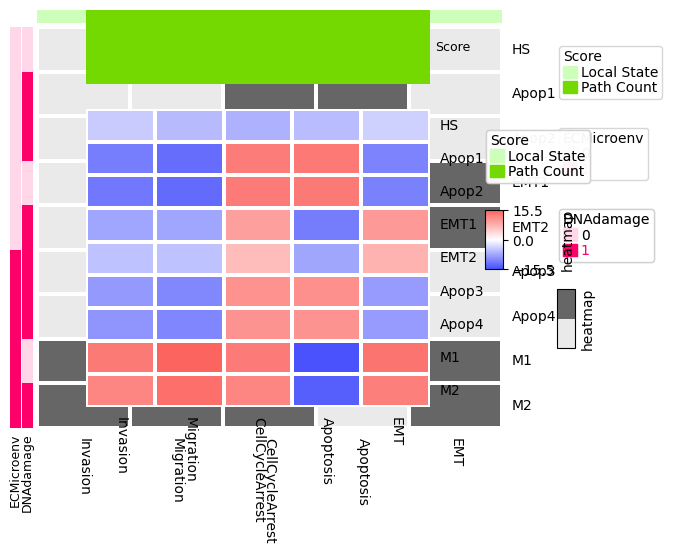

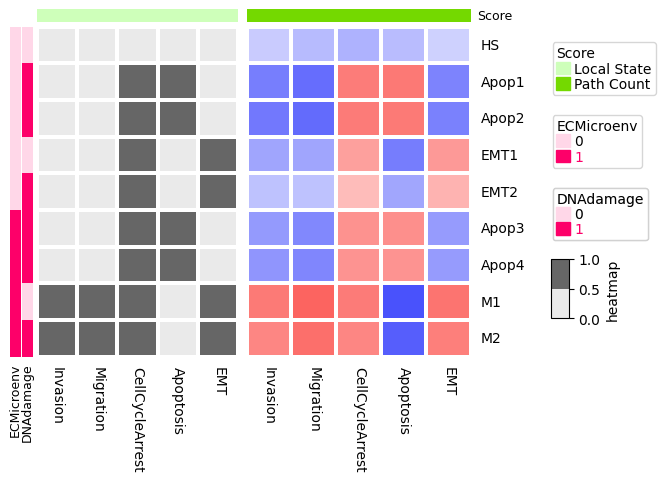

In [6]:
# Plot heatmap

# - Colors:
colors_col_ha = {"Score": {"Local State": "#CEFFBA", "Path Count": "#74D900"}}
colors_row_ha = {"ECMicroenv": {"0": "#FFD7E8", "1": "#FD0069"}, "DNAdamage": {"0": "#FFD7E8", "1": "#FD0069"}}

# - Annotations:
annot_ls = pd.DataFrame(["Local State"]*5, columns = ["Score"])
annot_paths = pd.DataFrame(["Path Count"]*5, columns = ["Score"])
annot_ls.index = annot_paths.index = paths_sum.columns
annot_inputs = model.Info.loc[["ECMicroenv", "DNAdamage"], model.Info.columns[:-2]].transpose().astype(str)
annot_inputs.index = paths_sum.index

col_ha_ls = HeatmapAnnotation(df = annot_ls, colors = colors_col_ha, plot = False, legend = True, legend_gap = 5, hgap = 0.5, axis = 1, label_kws = dict(visible = False)) # Annotation for local states
col_ha_paths = HeatmapAnnotation(df = annot_paths, colors = colors_col_ha, plot = False, legend = True, legend_gap = 5, hgap = 0.5, axis = 1, label_kws = dict(size = 9)) # Annotation for path counts
row_ha_inputs = HeatmapAnnotation(df = annot_inputs, colors = colors_row_ha, plot = False, legend = True, axis = 0, label_kws = dict(size = 9), label_side = "bottom") # Annotation for inputs

# - Subheatmap 1: Local States
cmap_ls = ListedColormap(["#EAEAEA", "#666666"])
hmap_ls = ClusterMapPlotter(
    ls_info,
    row_cluster = False, col_cluster = False,
    show_rownames = True, show_colnames = True,
    cmap = cmap_ls, linewidths = 1.5, linecolor = "white",
    plot_legend = True, top_annotation = col_ha_ls,
    left_annotation = row_ha_inputs
)

# - Subheatmap 2: Path Count
cmap_paths = LinearSegmentedColormap.from_list("custom_diverging", ["#464FFC", "#FFFFFF", "#FC6460"], N = 256)
vmax_paths = np.max(np.abs(paths_sum.values))
hmap_paths = ClusterMapPlotter(
    paths_sum,
    row_cluster = False, col_cluster = False,
    show_rownames = True, show_colnames = True,
    cmap = cmap_paths, vmin = -vmax_paths, vmax = vmax_paths,
    linewidths = 1.5, linecolor = "white",
    plot_legend = True, top_annotation = col_ha_paths
)

# - Merge subheatmaps
hmap_list = [hmap_ls, hmap_paths]
plt.figure(figsize = (6, 4))
ax, legend_axes = composite(cmlist = hmap_list, main = 0, col_gap = 0.1, legend_hpad = 50)
plt.savefig("Figures/pdf/Figure_3.pdf")
plt.savefig("Figures/png/Figure_3.png")

<p> 
    <b>Figure 3. </b>Heatmap showing the local states (left) and the corresponding paths (right) that trigger these states for the phenotype nodes in the SS reached by the metastatic model. The local states of the DNAdamage and ECMicroenv input nodes driving each SS are also displayed. Active nodes are represented in dark gray and inactive nodes are represented in light gray. The number of paths is presented on a log scale. Inactivating paths are displayed in blue, while activating paths are shown in red. TGFb: tumor growth factor beta; ECM: extracellular microenvironment; EMT: epithelial-to-mesenchymal transition; HS: homeostatic state; Apop: apoptosis; M: metastasis.
</p>

<h4 style="margin-top: 0px; margin-bottom: 2px;" id="section-3"><b>3.- Study perturbation effects in signal transduction</b></h4>

In [7]:
# - Set perturbations and target node readouts
pert_list = ["Unperturbed"] + [f"{node}%INH" if i % 2 == 0 else f"{node}%ACT" for node in list(model.Info.index) if node not in ["ECMicroenv", "DNAdamage", "Metastasis", "TGFbeta_i", "TGFbeta_e", "Invasion", "Migration", "CellCycleArrest", "Apoptosis", "EMT"] for i in range(2)]
phenotypes = ["Invasion", "Apoptosis"]

# - Generate perturbed models and perform SS and transduction analysis
pert_effects = {}
ls = {} 
stimes = []
for perturb in pert_list:
    if perturb != "Unperturbed":
        pmodel = model.Pert(perturb)
        ptype = perturb.split("%")[1]
        pnode = perturb.replace("%", "_")
        pmodel.Info = pmodel.Info.loc[:, (pmodel.Info.loc[["ECMicroenv"]] == 1).all(axis = 0) | pmodel.Info.columns.str.contains("DNF")]
    else:
        pmodel = model
        pmodel.Info = pmodel.Info.loc[:, (pmodel.Info.loc[["ECMicroenv"]] == 1).all(axis = 0) | pmodel.Info.columns.str.contains("DNF")]
        ptype = None
    print("Analyzing perturbation: ", perturb)
    ti = time.time()
    paths = pmodel.CountPaths(phenotypes, ss_wise = True)
    tf = time.time() - ti
    stimes.append(tf)
    try:
        for ss in range(len(paths)):
            if ptype != None: ss_name = perturb.replace("%", "_") + "_" + str(ss)
            elif ptype == None: ss_name = perturb + "_" + str(ss)
            pert_effects[ss_name] = {}
            ls[ss_name] = {}
            for phenotype in range(len(paths[ss])):
                pert_effects[ss_name][phenotypes[phenotype]] = paths[ss][phenotype]
                ls[ss_name][phenotypes[phenotype]] = pmodel.Info.at[phenotypes[phenotype], pmodel.Info.columns[ss]]
    except:
        print("No SS found, skipping...")
        continue       

Analyzing perturbation:  Unperturbed
Evaluating Stable State: 5
Invasion: -7297, 0.0009204030036926269 minutes.
Apoptosis: 69198, 0.007263088226318359 minutes.
Evaluating Stable State: 7
Invasion: -10026, 0.00209505558013916 minutes.
Apoptosis: 47620, 0.009125971794128418 minutes.
Evaluating Stable State: 2
Invasion: 554895, 0.04403680960337321 minutes.
Apoptosis: -4106274, 0.28202754259109497 minutes.
Evaluating Stable State: 3
Invasion: 179328, 0.0260131041208903 minutes.
Apoptosis: -1376996, 0.18113864660263063 minutes.
Analyzing perturbation:  TGFbeta%INH
Evaluating Stable State: 15
Invasion: -57701, 0.003455082575480143 minutes.
Apoptosis: 492301, 0.03160258531570435 minutes.
Evaluating Stable State: 3
Invasion: -70028, 0.006639087200164795 minutes.
Apoptosis: 288773, 0.024683988094329833 minutes.
Evaluating Stable State: 11
Invasion: -99178, 0.009646197160085043 minutes.
Apoptosis: -2542714, 0.1970018227895101 minutes.
Evaluating Stable State: 10
Invasion: -24138, 0.0044757962226

In [8]:
# Retrieve SS-wise and model-wise information

# - SS-wise information
SSwise_res = pd.DataFrame(pert_effects).transpose()
SSwise_res.columns = ["paths_invasion", "paths_apoptosis"]
SSwise_res["paths_death_resistandce"] = SSwise_res["paths_apoptosis"]*(-1)
SSwise_res = pd.concat([SSwise_res, pd.DataFrame(ls).transpose()], axis = 1)
SSwise_res.columns = ["paths_invasion", "paths_apoptosis", "paths_apop_resistance", "ls_invasion", "ls_apoptosis"]
SSwise_res["ls_apop_resistance"] = SSwise_res["ls_apoptosis"]*(-1) + 1
for col in list(SSwise_res.columns):
    SSwise_res[f"{col}_sc"] = sc_custom(SSwise_res[col], SSwise_res[col].min())
SSwise_res["Perturbation"] = SSwise_res.index.str.rsplit("_", n = 1).str[0]

zero_equiv_invasion = (0 - SSwise_res["paths_invasion"].min())/(SSwise_res["paths_invasion"].max() - SSwise_res["paths_invasion"].min()) # Get coordinates for 0 after scalation
zero_equiv_apop_resistance = (0 - SSwise_res["paths_apop_resistance"].min())/(SSwise_res["paths_apop_resistance"].max() - SSwise_res["paths_apop_resistance"].min()) # Get coordinates for 0 after scalation

# - Model-wise information
Mwise_res = SSwise_res.groupby("Perturbation").mean()
Mwise_res.loc[:, ["paths_invasion", "paths_apoptosis", "paths_death_resistance"]] = Mwise_res.loc[:, ["paths_invasion", "paths_apoptosis", "paths_apop_resistance"]].apply(lambda x: np.round(pd.to_numeric(x), 5))
for col in list(Mwise_res.columns):
    Mwise_res[f"{col}_sc"] = sc_custom(Mwise_res[col], Mwise_res.loc["Unperturbed", col])

<h5 style="margin-top: 0px; margin-bottom: 2px;" id="section-3.1"><b>3.1.- Figure 4:</b> phenotype ranges across perturbations.</h5>

/tmp/ipykernel_19790/67905674.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[f"{col}_sc"] = sc_custom(abs(filtered_data[col]), abs(filtered_data[col]).min())
/tmp/ipykernel_19790/67905674.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[f"{col}_sc"] = sc_custom(abs(filtered_data[col]), abs(filtered_data[col]).min())
/tmp/ipykernel_19790/67905674.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

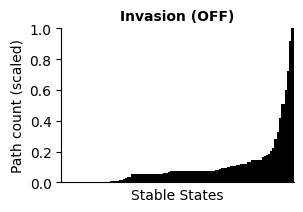

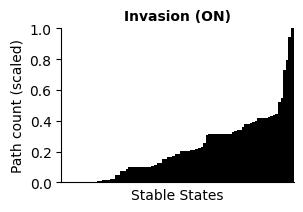

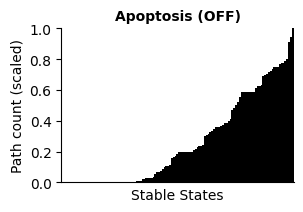

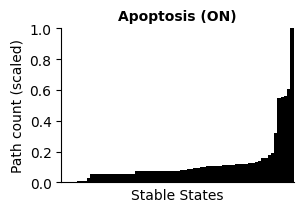

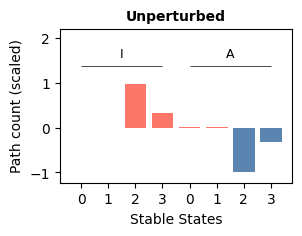

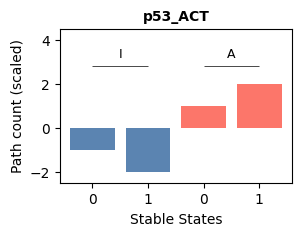

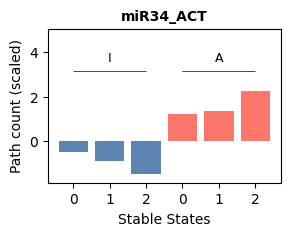

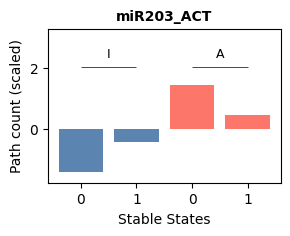

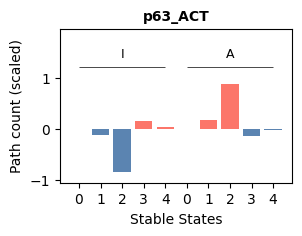

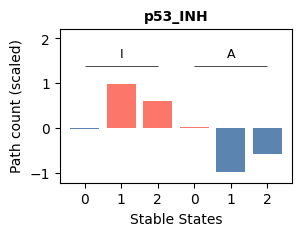

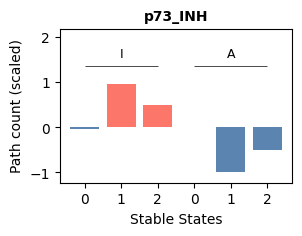

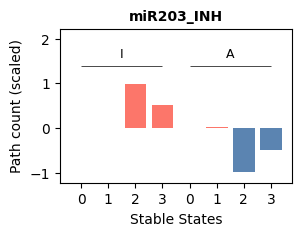

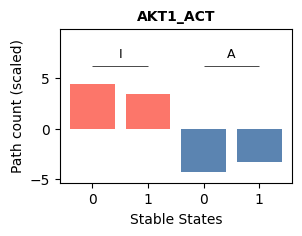

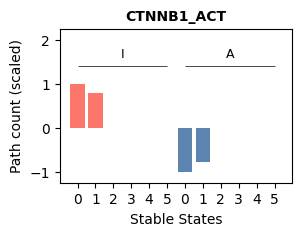

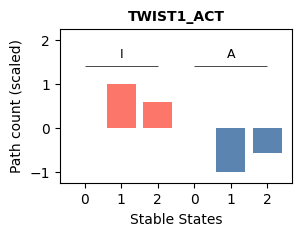

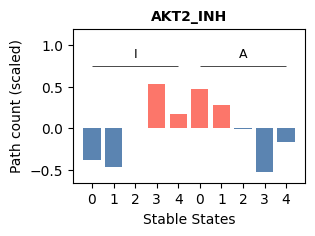

In [9]:
# Plot phenotype ranges
plotrange(SSwise_res, "down", "paths_invasion", 3, 2, "Invasion (OFF)"); plt.savefig("Figures/pdf/Figure_4A.pdf", dpi = 300, bbox_inches = "tight"); plt.savefig("Figures/png/Figure_4A.png") # (A)
plotrange(SSwise_res, "up", "paths_invasion", 3, 2, "Invasion (ON)"); plt.savefig("Figures/pdf/Figure_4B.pdf", dpi = 300, bbox_inches = "tight"); plt.savefig("Figures/png/Figure_4B.png") # (B)
plotrange(SSwise_res, "down", "paths_apoptosis", 3, 2, "Apoptosis (OFF)"); plt.savefig("Figures/pdf/Figure_4C.pdf", dpi = 300, bbox_inches = "tight"); plt.savefig("Figures/png/Figure_4C.png") # (C)
plotrange(SSwise_res, "up", "paths_apoptosis", 3, 2, "Apoptosis (ON)"); plt.savefig("Figures/pdf/Figure_4D.pdf", dpi = 300, bbox_inches = "tight"); plt.savefig("Figures/png/Figure_4D.png") # (D)

# Plot pert effects on phenotypes
filtPerts = ["Unperturbed", "p53_ACT", "miR34_ACT", "miR203_ACT", "p63_ACT", "p53_INH", "p73_INH", "miR203_INH", "AKT1_ACT", "CTNNB1_ACT", "TWIST1_ACT", "AKT2_INH", "AKT2_ACT"]
for perturb, letter in zip(filtPerts, ["E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P"]): # (E-P)
    pert_bp_data = SSwise_res[SSwise_res.index.str.startswith(tuple([perturb]))]
    pert_bp = SSbars(pert_bp_data, ["paths_invasion", "paths_apoptosis"], 3, 2, ["I", "A"])
    plt.savefig(f"Figures/pdf/Figure_4{letter}.pdf", dpi = 300, bbox_inches = "tight"); plt.savefig(f"Figures/png/Figure_4{letter}.png")

<p>
    <b>Figure 4: </b>The distribution of path counts leading to the local states of the Invasion and Apoptosis phenotype nodes. Each bar represents the min-max scaled score of a stable state reached upon one of the node additive perturbations leading to Invasion activation (A), inactivation (B), and Apoptosis activation (C), and inactivation (D). E-P. Barplots showing the 0-centered, min-max scaled path count score leading to the local states of Invasion and Apoptosis phenotype nodes. Each plot represents a perturbation, and bars delimited by I  and A the path count scores resulting in the inactivation (blue) or activation (red) of the Invasion and Apoptosis phenotype nodes.
</p>


<h5 style="margin-top: 0px; margin-bottom: 2px;" id="section-3.2"><b>3.2.- Figure 5:</b> Invasion-Apoptosis resistance.</h5>

/tmp/ipykernel_19790/67905674.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(ax.text(data[x][i], data[y][i], str(data.index[i]), fontsize = 8, color = "black"))
Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


0.5125375172766236 0.0001665062489400689


/tmp/ipykernel_19790/67905674.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(ax.text(data[x][i], data[y][i], str(data.index[i]), fontsize = 8, color = "black"))
/tmp/ipykernel_19790/67905674.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(ax.text(data[x][i], data[y][i], str(data.index[i]), fontsize = 8, color = "black"))


0.5125375172766236 0.0001665062489400689
0.9455042089087679 1.5263647489643362e-24
0.9455042089087679 1.5263647489643362e-24


/tmp/ipykernel_19790/67905674.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  texts.append(ax.text(data[x][i], data[y][i], str(data.index[i]), fontsize = 8, color = "black"))


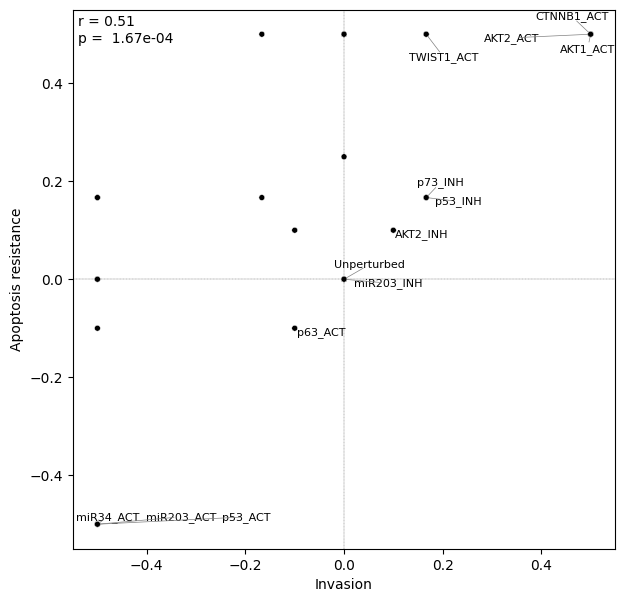

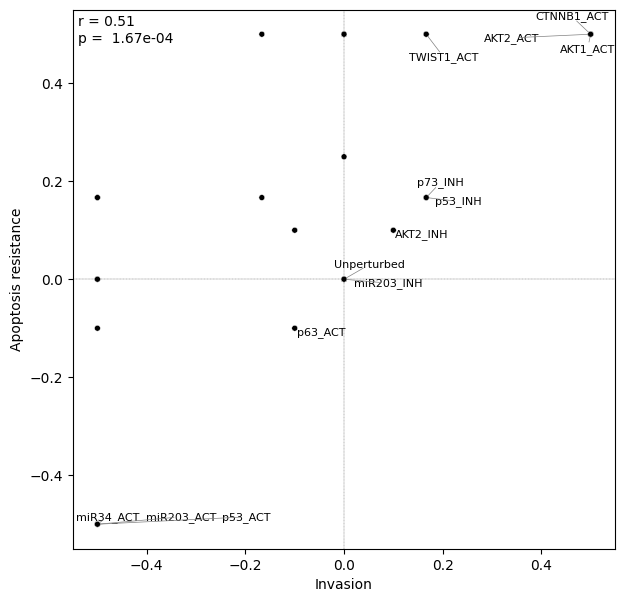

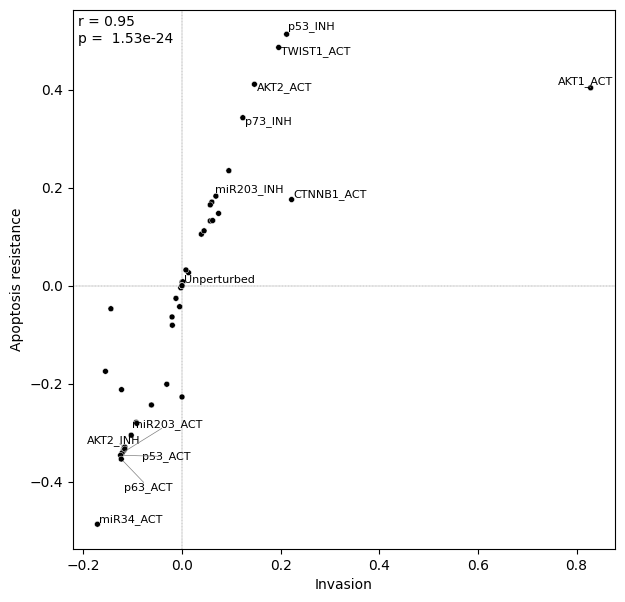

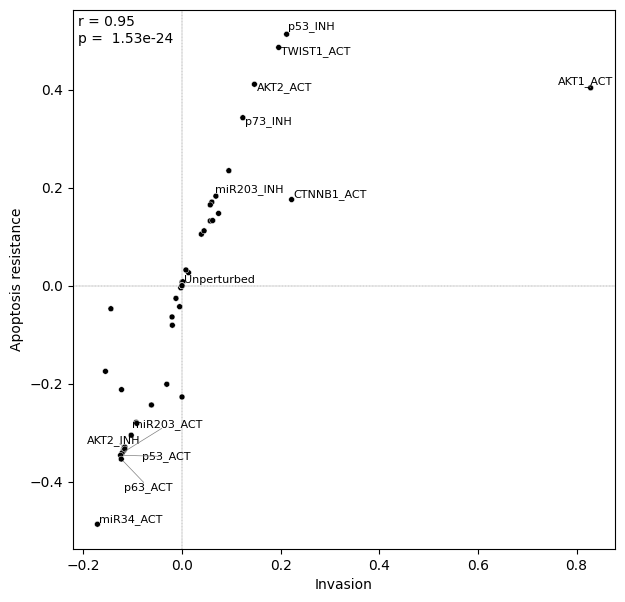

In [10]:
# Generate scatter plots
scatter_plot_custom(Mwise_res, "ls_invasion_sc", "ls_apop_resistance_sc", "Invasion", "Apoptosis resistance", "Figures/png/Figure_5A.png", labs = filtPerts); scatter_plot_custom(Mwise_res, "ls_invasion_sc", "ls_apop_resistance_sc", "Invasion", "Apoptosis resistance", "Figures/pdf/Figure_5A.pdf", labs = filtPerts) # Local states (png, pdf)
scatter_plot_custom(Mwise_res, "paths_invasion_sc", "paths_apop_resistance_sc", "Invasion", "Apoptosis resistance", "Figures/png/Figure_5B.png", labs = filtPerts); scatter_plot_custom(Mwise_res, "paths_invasion_sc", "paths_apop_resistance_sc", "Invasion", "Apoptosis resistance", "Figures/pdf/Figure_5B.pdf", labs = filtPerts) # Path counts (png, pdf)

<p>
    <b>Figure 5: A. </b>Scatterplot depicting the impact of individual node additive perturbations on the local states of the Invasion (X-axis) and Apoptosis (Y-axis) phenotype nodes. <b>B. </b>Scatterplot depicting the impact of individual node perturbations oin the path counts triggering the activation or inhibition of the Invasion (X-axis) and Apoptosis (Y-axis) phenotype nodes. Invasion and apoptosis scores are presented as the Unperturbed-centered, min-max escalation of the average Invasion and 1-Apoptosis local states (A) and path counts (B) across the stable states of each perturbation. Spearman correlation coefficient (r) and associated p-values are annotated in the upper-left corner of each plot. 
</p>    

<h4 style="margin-top: 0px; margin-bottom: 2px;" id="section-4"><b>4.- Supplementary Figures</b></h4>

<h5 style="margin-top: 0px; margin-bottom: 2px;" id="section-4.1"><b>4.1.- Supplementary Figure S1:</b> BooLEVARD's performance.</h5>

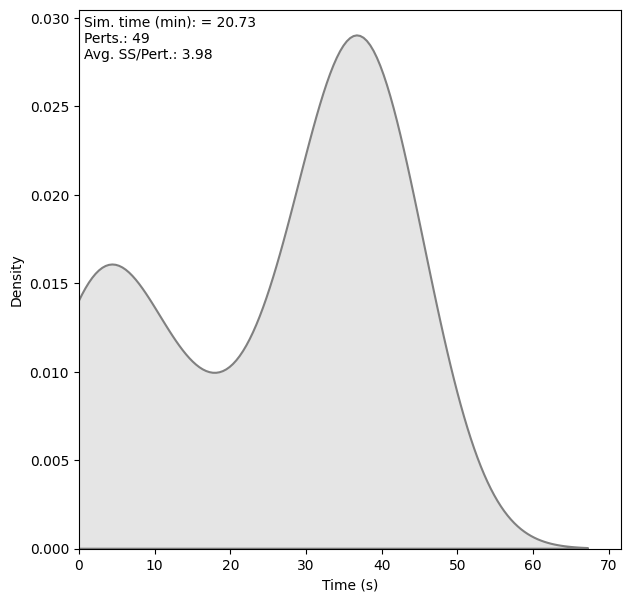

In [11]:
# Simulation times
pert_count = len(pert_list)
SS_count = len(stimes)
stime = round(sum(stimes), 2)
plt.figure(figsize = (7, 7))
sb.kdeplot(stimes, fill = True, color = "gray", linewidth = 1.5, alpha = 0.2)
plt.xlim(0, None)
plt.text(0.01, 0.99, f"Sim. time (min): = {round(stime/60, 2)}\nPerts.: {pert_count}\nAvg. SS/Pert.: {round((len(pert_effects)-4)/pert_count, 2)}", transform = plt.gca().transAxes, fontsize = 10, verticalalignment = "top", horizontalalignment = "left")
plt.xlabel("Time (s)")
plt.savefig("Figures/pdf/Figure_S1.pdf", dpi = 300, bbox_inches = "tight"); plt.savefig("Figures/png/Figure_S1.png", dpi = 300, bbox_inches = "tight")

<p>
    <b>Supplementary Figure S1: </b> Density plot illustrating the distribution of BooLEVARD’s simulation times for each processed stable state.
</p>

<h5 style="margin-top: 0px; margin-bottom: 2px;" id="section-4.2"><b>4.2.- Perturbation stable state analysis</b></h5>

In [12]:
# Process data
pert_list = ["Unperturbed"] + [f"{node}%INH" if i % 2 == 0 else f"{node}%ACT" for node in list(model.Info.index) if node not in ["ECMicroenv", "DNAdamage", "Metastasis", "TGFbeta_i", "TGFbeta_e", "Invasion", "Migration", "CellCycleArrest", "Apoptosis", "EMT"] for i in range(2)]
stable_states = []

# - Perturbations
for p in pert_list[1:]:
    pmodel = model.Pert(p)
    SS_id = p.replace("%", "_")
    pm_SS = pmodel.Info.iloc[:, :-2]
    pm_SS = pm_SS.loc[:, (pm_SS.loc[["ECMicroenv", SS_id]] == 1).all(axis = 0)]
    pm_SS.columns = [f"{SS_id}_{i}" for i in range(len(pm_SS.columns))]
    stable_states.append(pm_SS)

# - Add unperturbed states
m_SS = model.Info.iloc[:, :-2]
m_SS = m_SS.loc[:, m_SS.loc["ECMicroenv"] == 1]
m_SS.columns = [f"Unperturbed_{i}" for i in range(len(m_SS.columns))]
stable_states.append(m_SS)

# - Generate dataframes to plot heatmaps
summary = pd.concat(stable_states, axis = 1).dropna().transpose().astype("int") # Every perturbation
mask = summary.index.str.startswith(tuple(filtPerts)) # Mask to order perturbations
summary_ordered = pd.concat([summary[mask], summary[~mask]])

<h5 style="margin-top: 0px; margin-bottom: 2px;"  id="section-4.2.1"><b>4.2.1.- Supplementary Figure S2:</b> Perturbation stable state analysis (filtered).</h5>

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


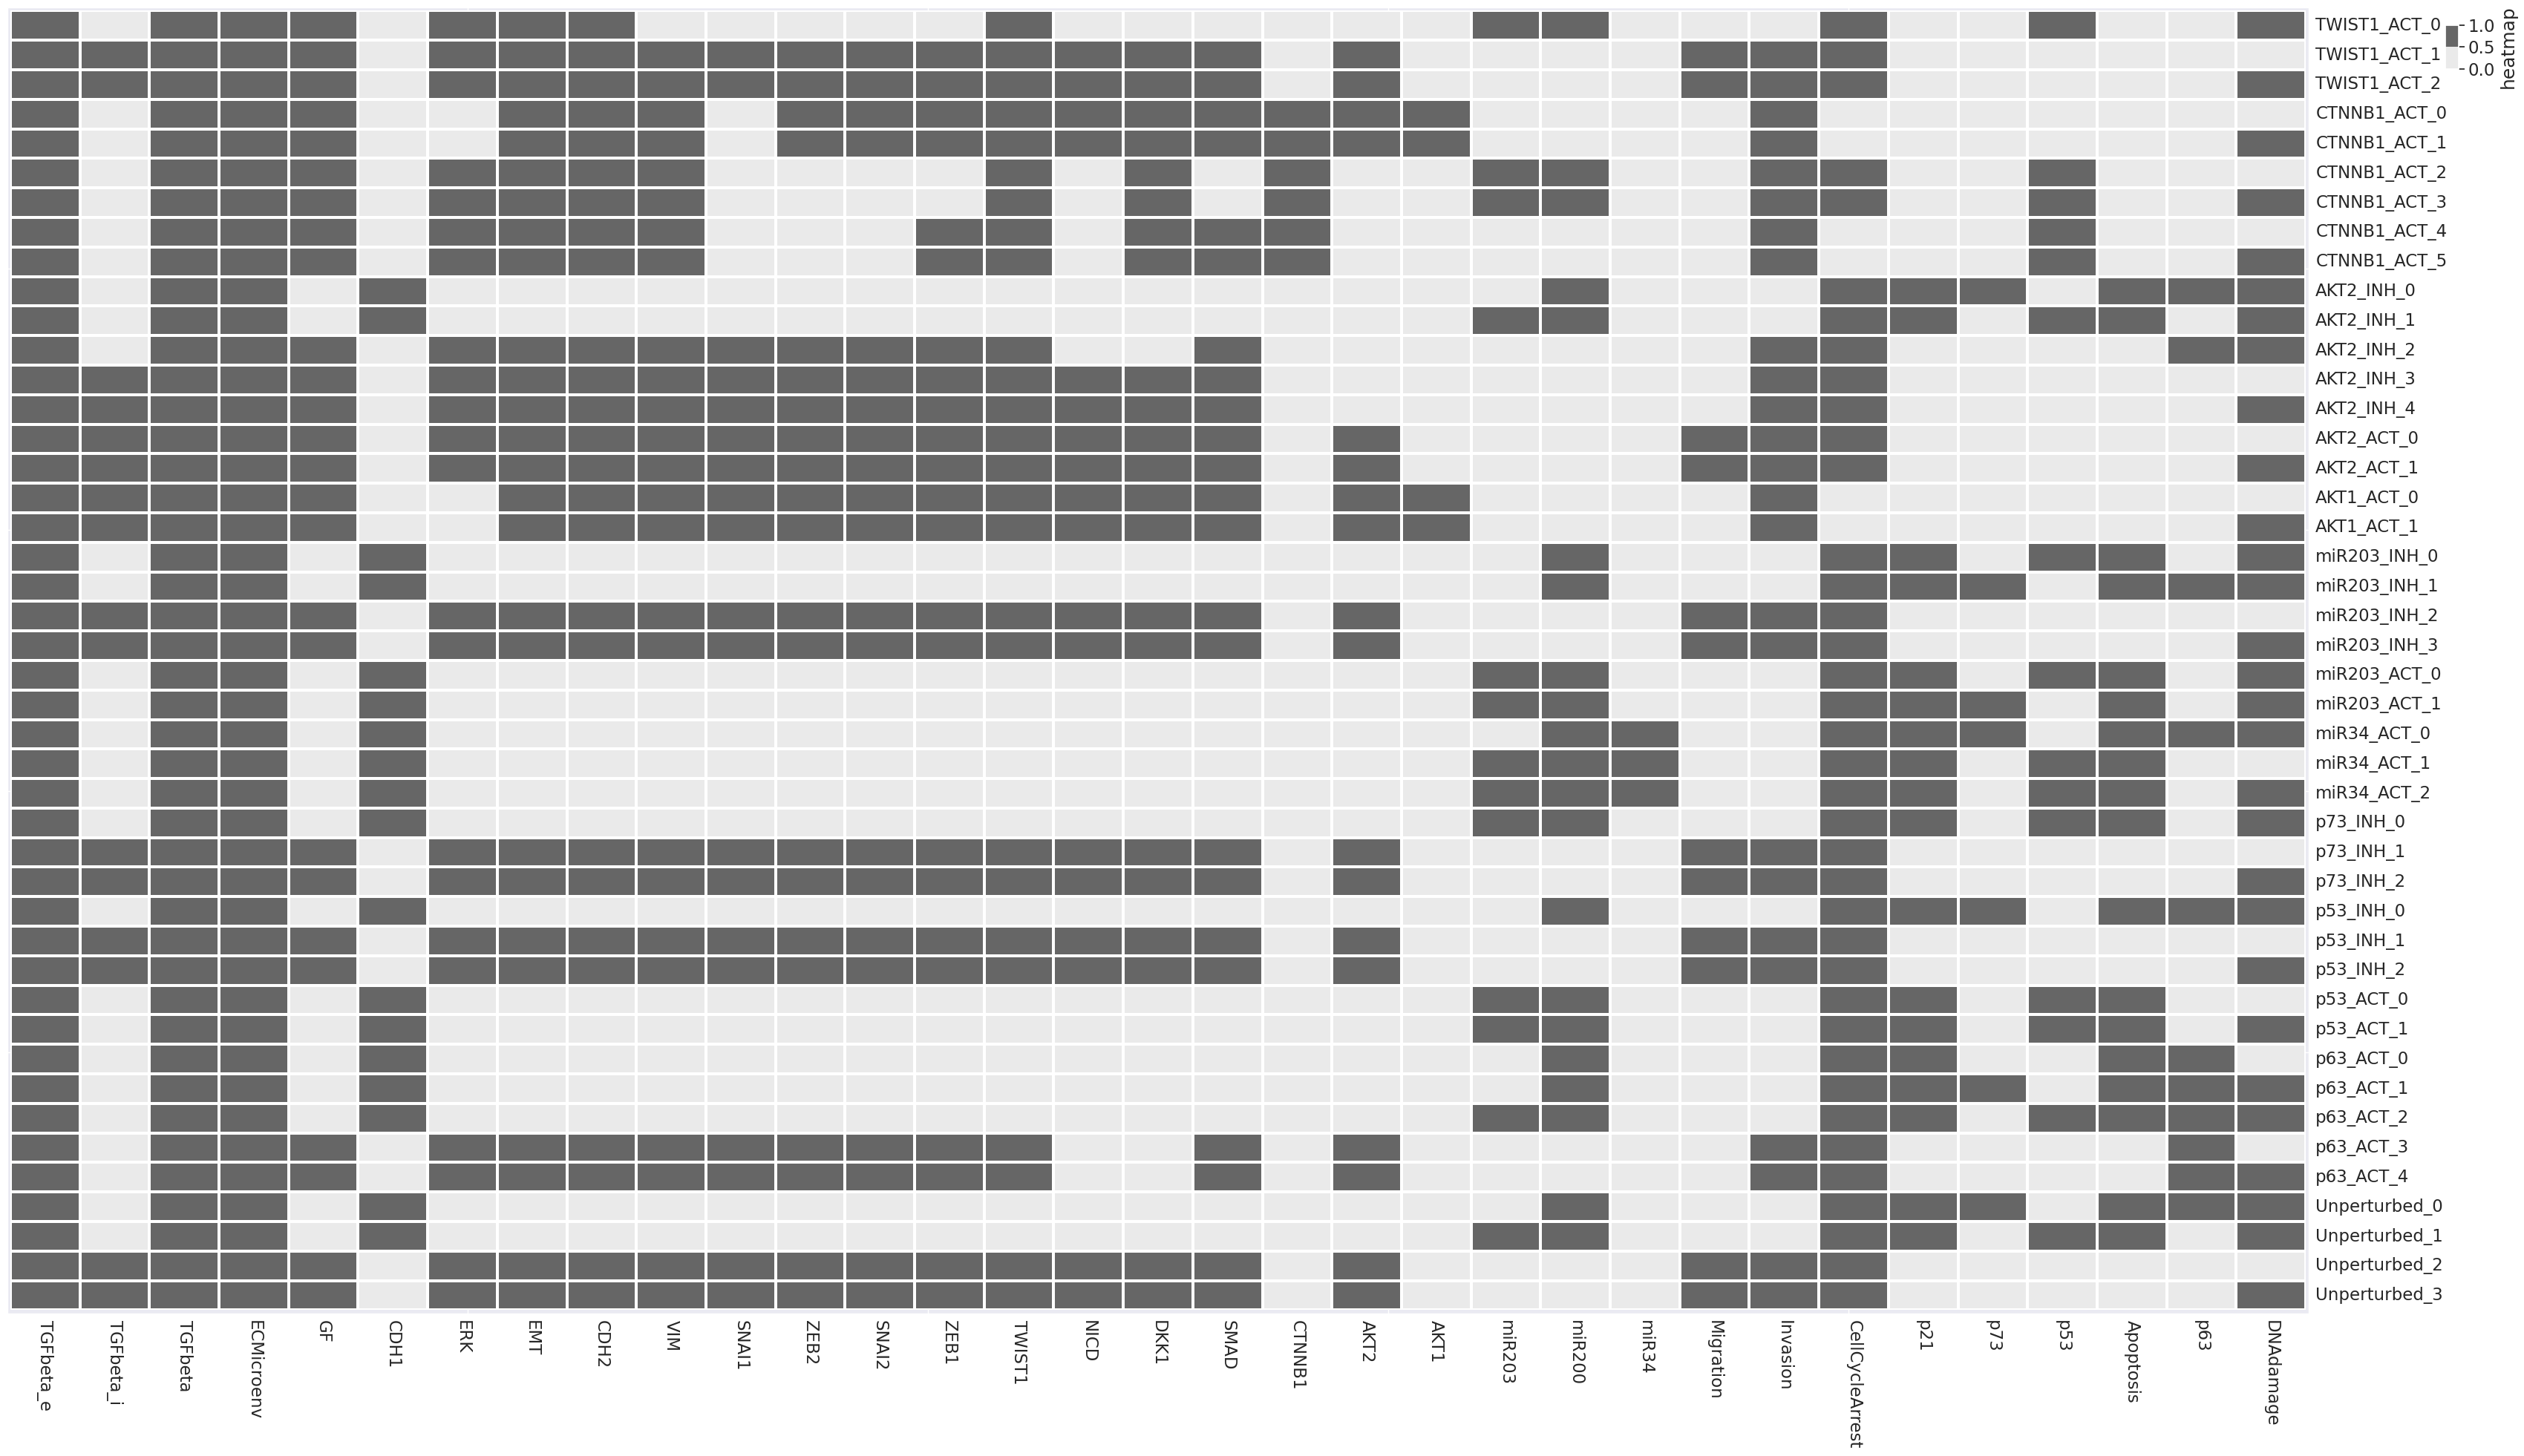

In [13]:
plt.figure(figsize = (40, 20))
sb.set(font_scale = 1.5)
cmap_perts = ListedColormap(["#EAEAEA", "#666666"])
hmap_perts_filt = ClusterMapPlotter(
    summary[mask],
    row_cluster = False, col_cluster = False,
    show_rownames = True, show_colnames = True,
    cmap = cmap_perts,
    linewidths = 1.5, linecolor = "white",
    plot_legend = True,
    col_names_side = "bottom"
)
plt.savefig("Figures/pdf/Figure_S2.pdf", dpi = 300, bbox_inches = "tight"); plt.savefig("Figures/png/Figure_S2.png", dpi = 300, bbox_inches = "tight")

<p>
    <b>Supplementary Figure S2: </b> Heatmap showing the stable states reached by the model upon perturbations discussed in Figure 4E-P. The local states of the input nodes driving each stable state are displayed in dark gray (ON) or light gray (OFF). ECMicroenv input node was set to 1 as a constraint in every perturbation.
</p>

<h5 style="margin-top: 0px; margin-bottom: 2px;" id="section-4.2.2"><b>4.2.2.- Supplementary Figure S3:</b> Perturbation stable state analysis (all).</h5>

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..
Estimated legend width: 7.5 mm


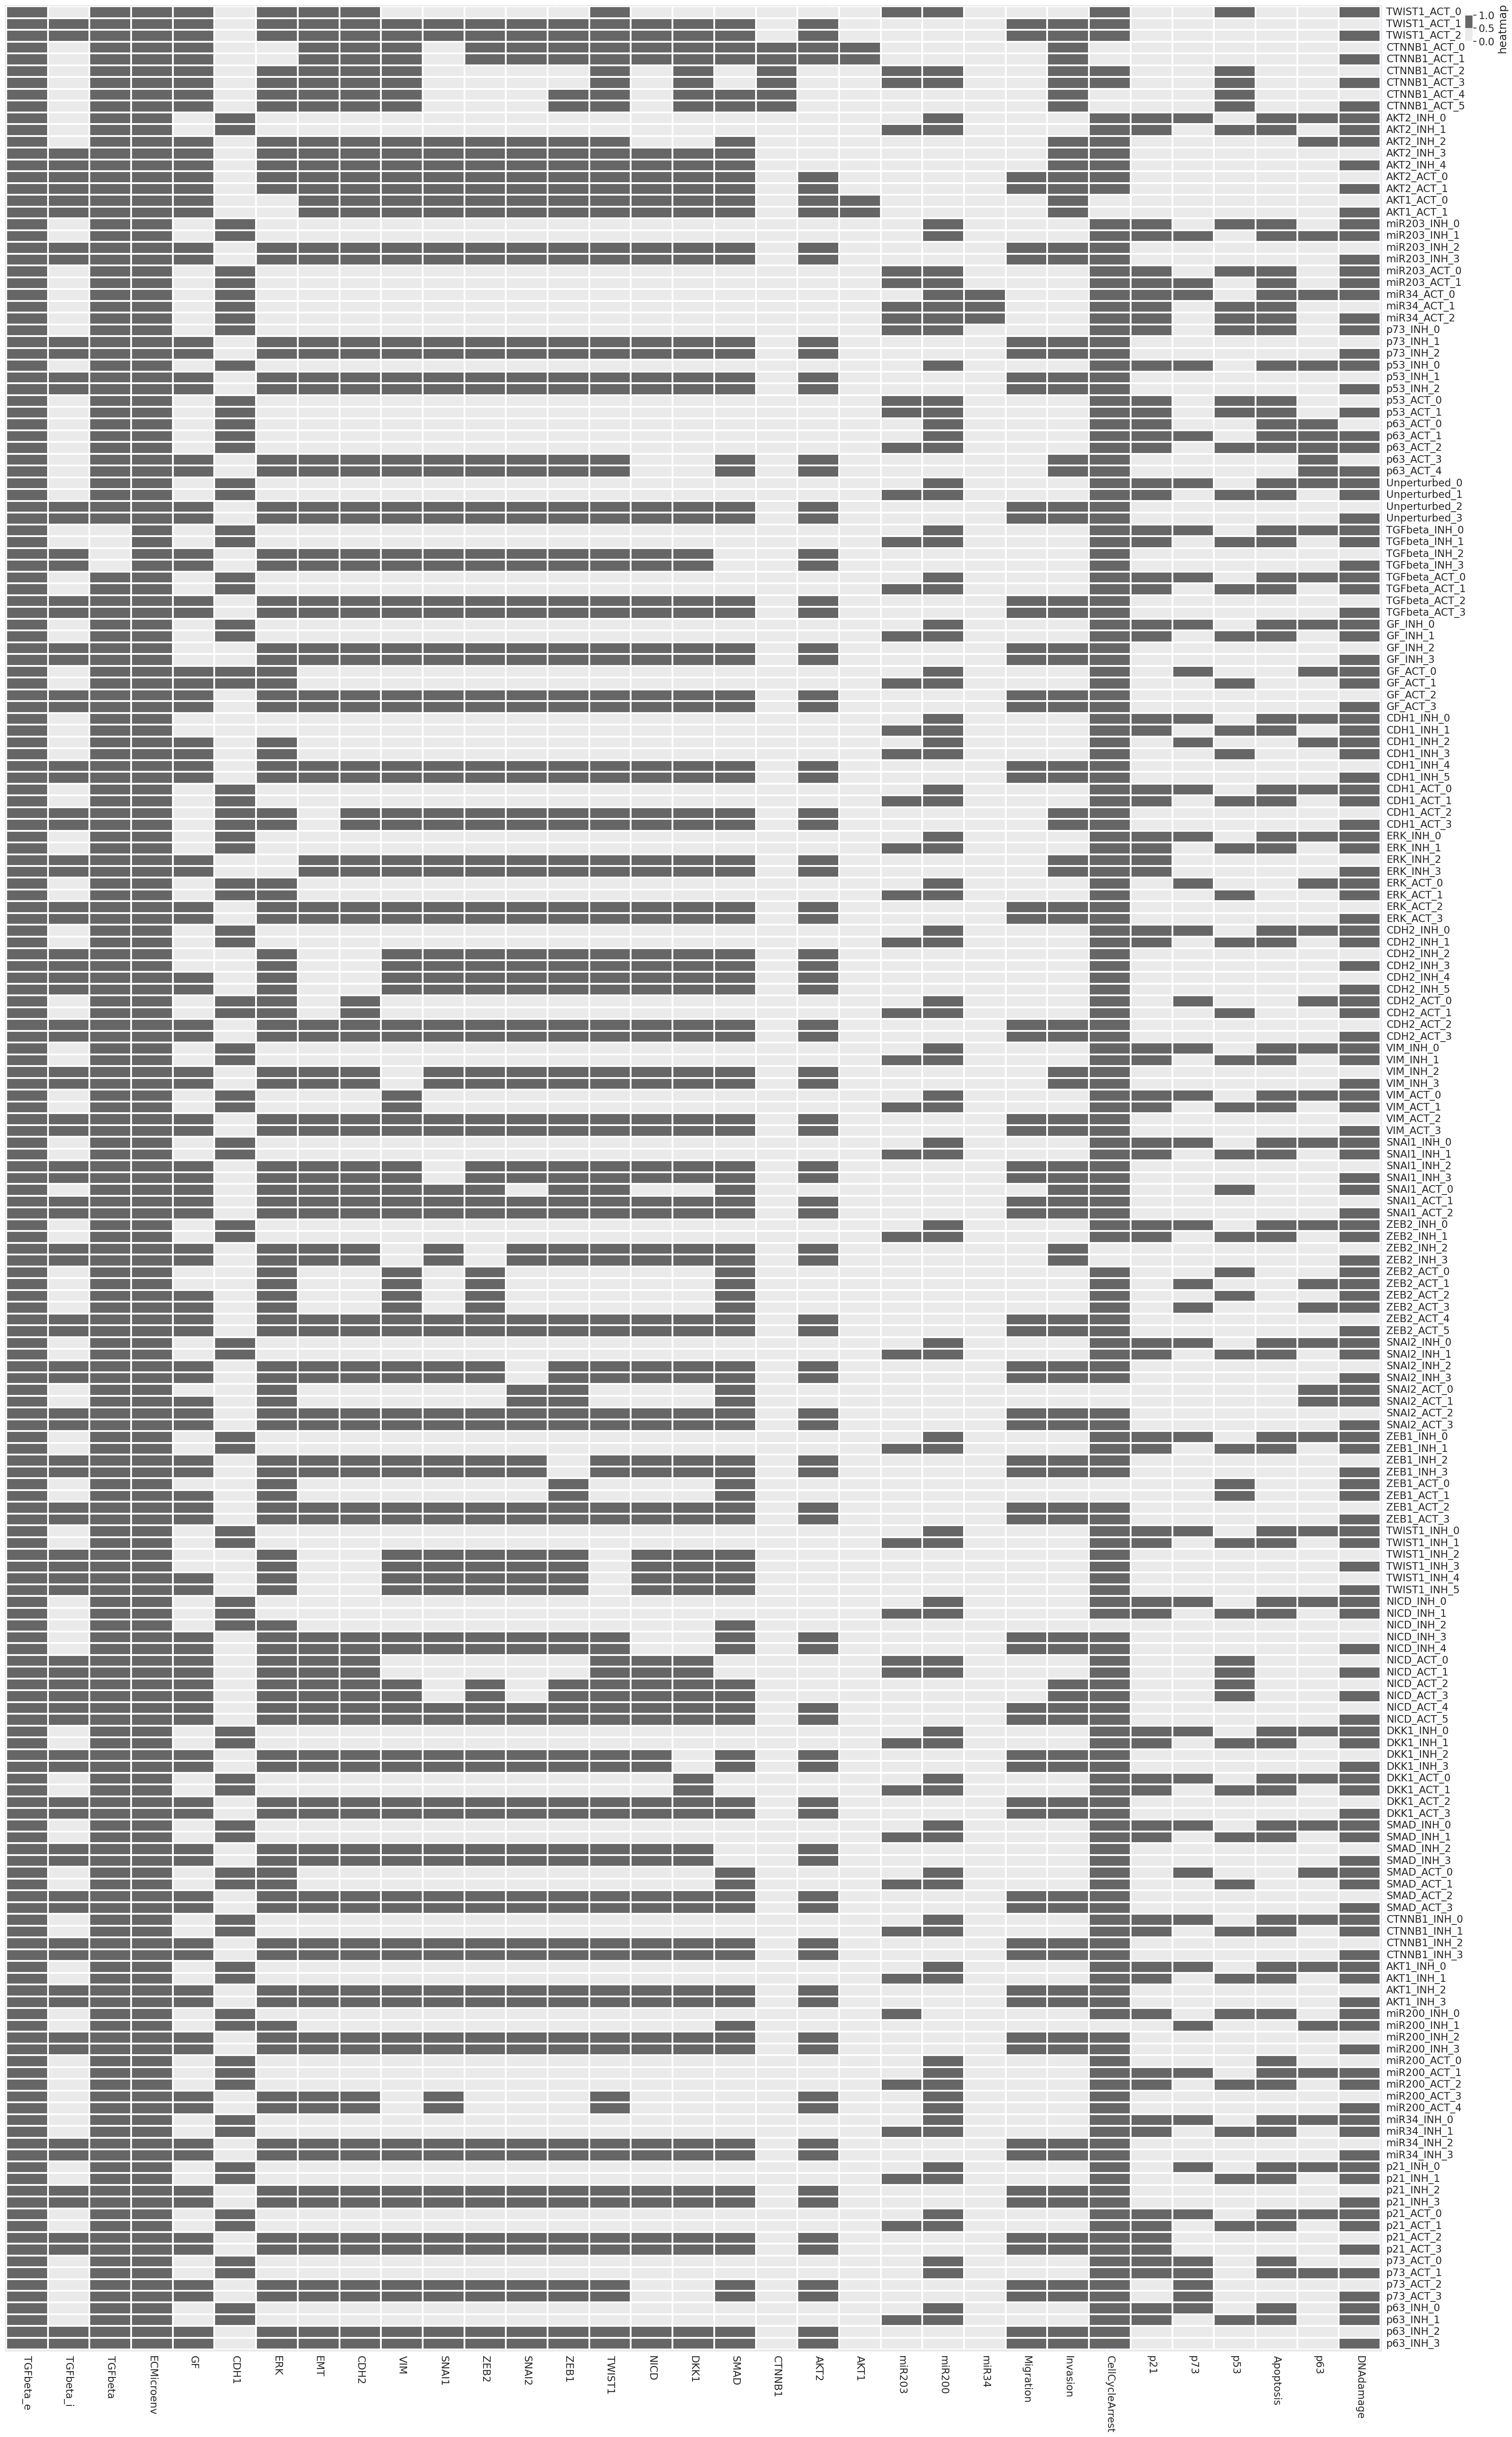

In [14]:
plt.figure(figsize = (40, 60))
sb.set(font_scale = 1.5)
hmap_perts = ClusterMapPlotter(
    summary_ordered,
    row_cluster = False, col_cluster = False,
    show_colnames = True, show_rownames = True,
    cmap = cmap_perts,
    linewidths = 1.5, linecolor = "white",
    plot_legend = True,
    col_names_side = "bottom"
)
plt.savefig("Figures/pdf/Figure_S3.pdf", dpi = 300, bbox_inches = "tight"); plt.savefig("Figures/png/Figure_S3.png", dpi = 300, bbox_inches = "tight")

<p>
    <b>Supplementary Figure S3: </b> Heatmap showing the stable states reached by the model upon every performed perturbation. The local states of the input nodes driving each stable state are displayed in dark gray (ON) or light gray (OFF). ECMicroenv input node was set to 1 as a constraint in every perturbation. 
</p>

<h5 style="margin-top: 0px; margin-bottom: 2px;"  id="section-4.3"><b>4.3.- Supplementary Figure S4: </b>Path counts impacting phenotypes across stable states.</h5>

/tmp/ipykernel_19790/67905674.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[f"{col}_sc"] = sc_custom(abs(filtered_data[col]), abs(filtered_data[col]).min())
/tmp/ipykernel_19790/67905674.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bplot = sb.barplot(x = filtered_data.index, y = f"{col}_sc", data = filtered_data, palette = colors, ax = ax)
/tmp/ipykernel_19790/67905674.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
/tmp/ipykernel_19790/67

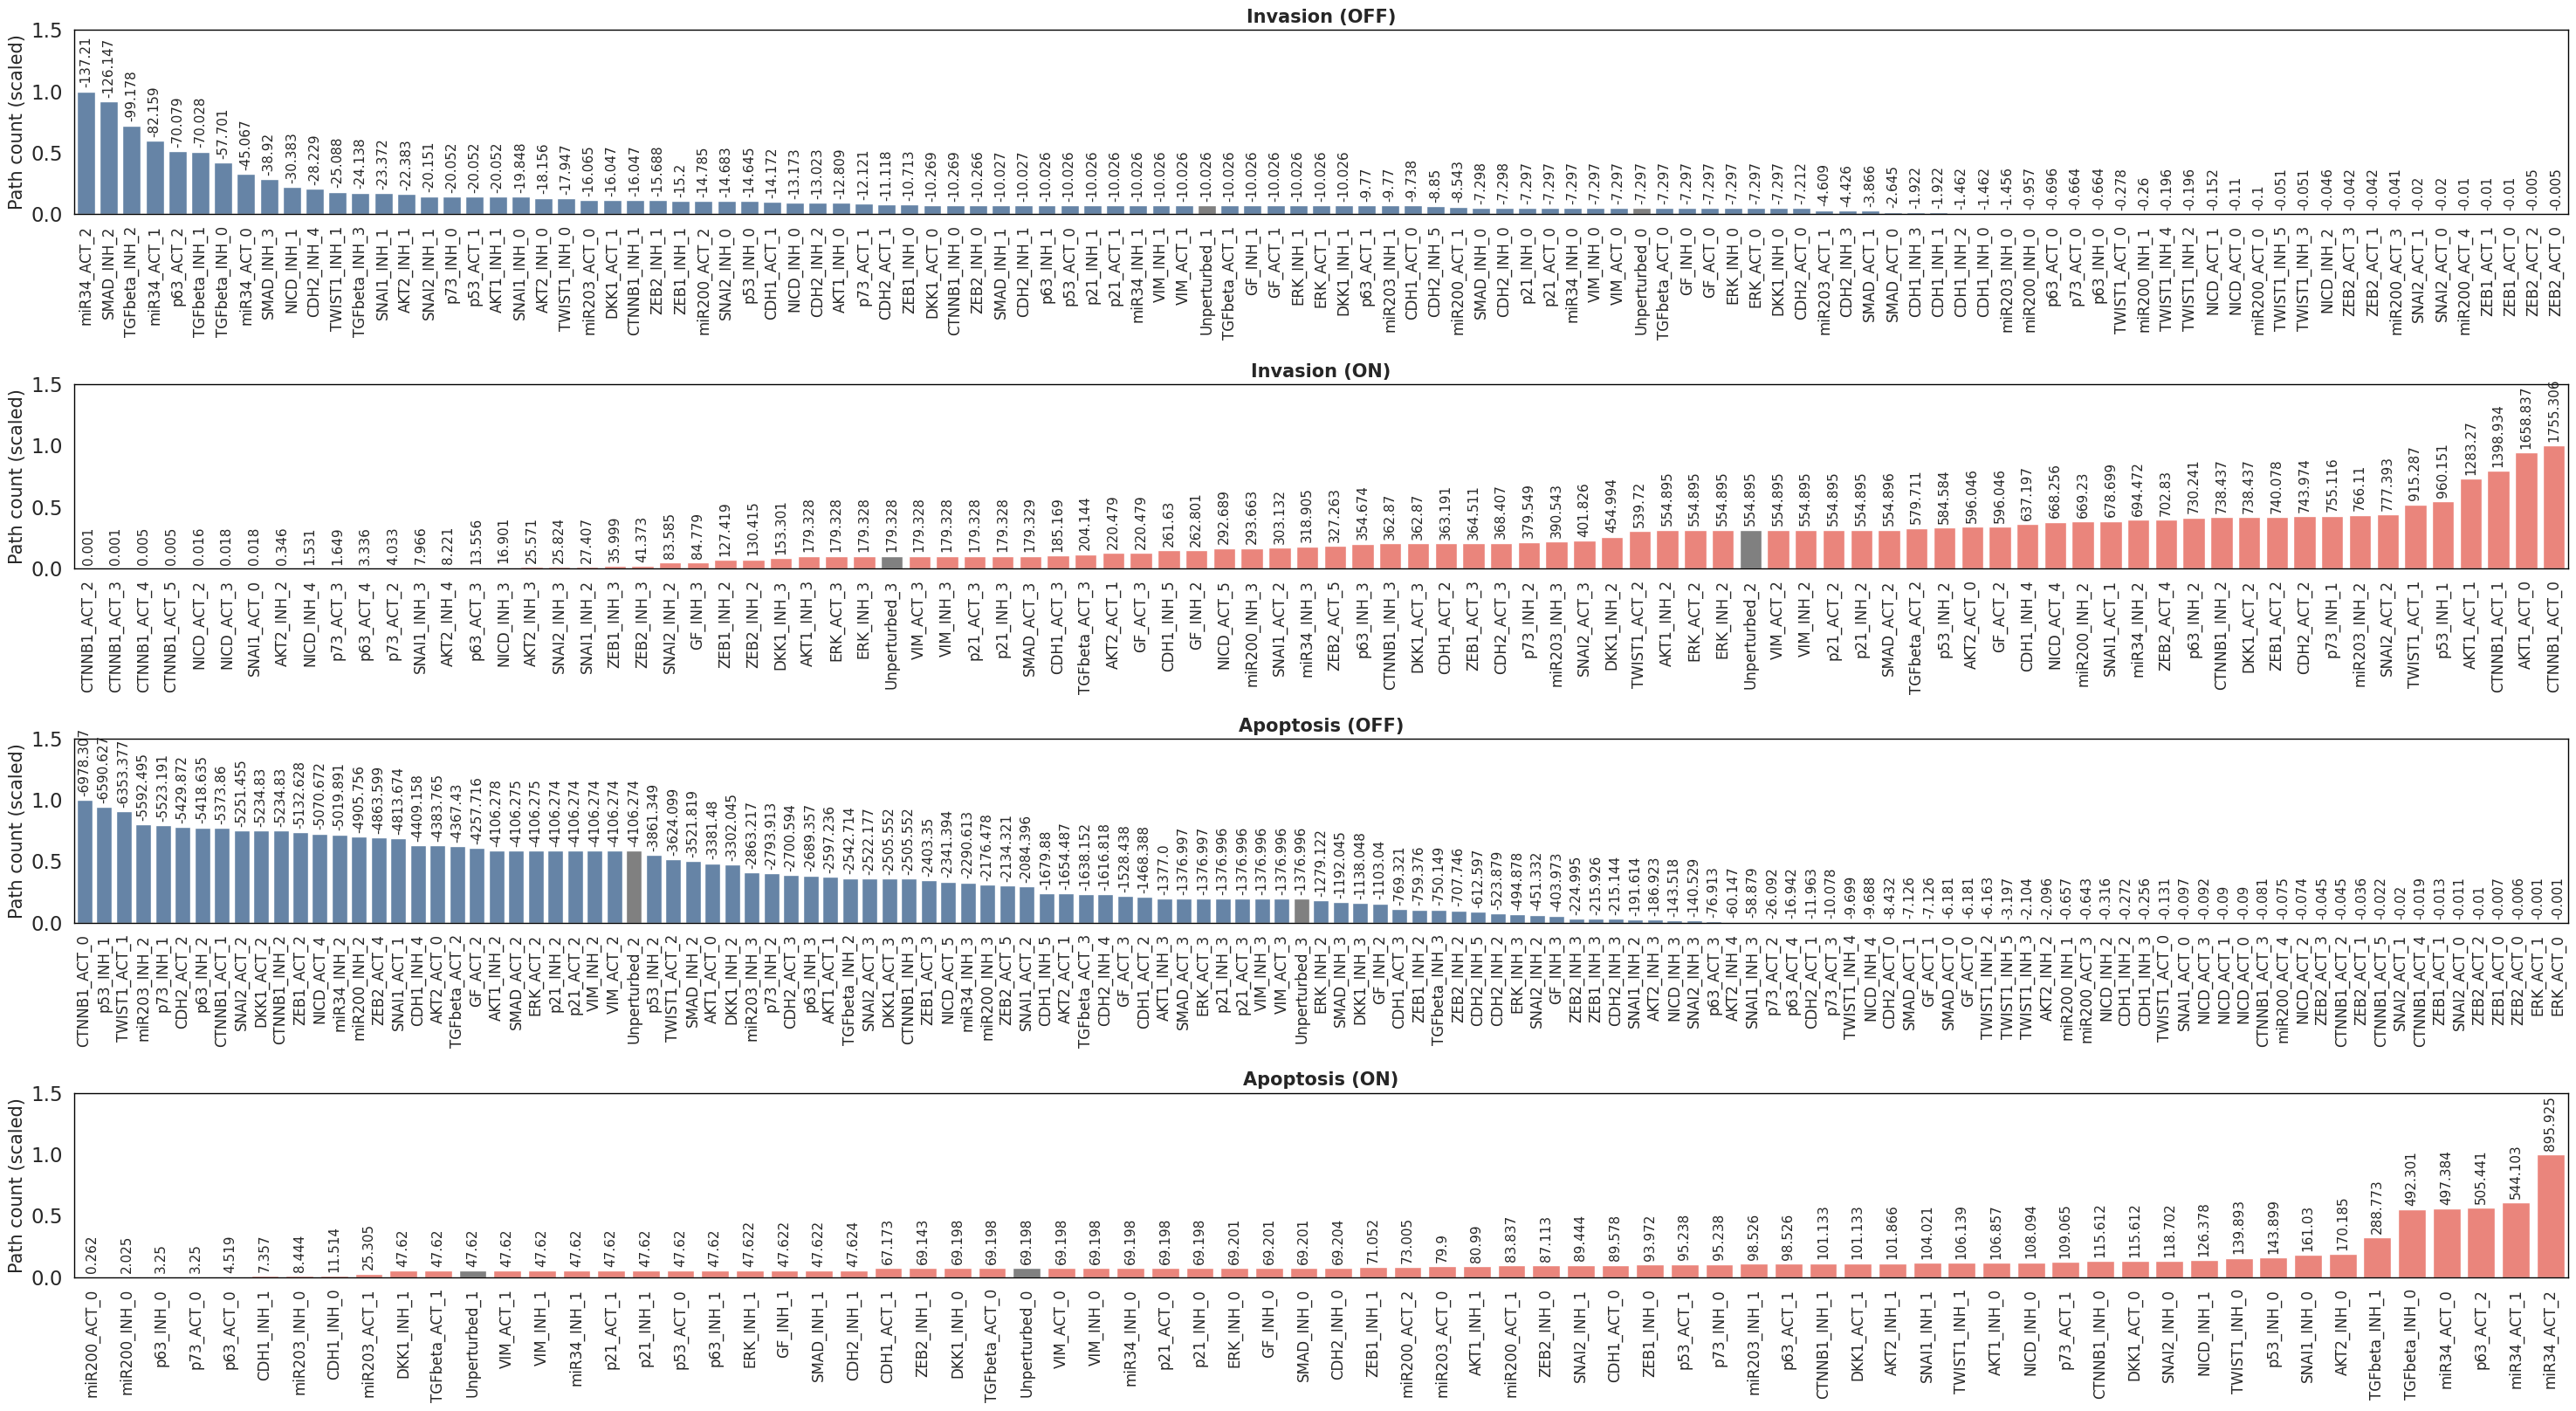

In [15]:
fig, axes = plt.subplots(4, 1, figsize = (30, 16.5))
StudyStrength(SSwise_res, "down", "paths_invasion", 16, 5, "Invasion (OFF)", ax = axes[0])
StudyStrength(SSwise_res, "up", "paths_invasion", 16, 5, "Invasion (ON)", ax = axes[1])
StudyStrength(SSwise_res, "down", "paths_apoptosis", 16, 5, "Apoptosis (OFF)", ax = axes[2])
StudyStrength(SSwise_res, "up", "paths_apoptosis", 16, 5, "Apoptosis (ON)", ax = axes[3])
plt.tight_layout()
plt.savefig("Figures/pdf/Figure_S4.pdf"); plt.savefig("Figures/png/Figure_S4.png")

<p>
    <b>Supplementary Figure S4: </b>Barplots illustrating the min-max scaled path counts for the Invasion and Apoptosis across each SS of all model perturbations performed . From top to bottom: path counts leading to the inactivation of Invasion, path counts leading to the activation of Invasion, path counts leading to the inactivation of Apoptosis, path counts leading to the activation of Apoptosis. Red and blue bars represent SS reached upon the perturbations resulting in an active or inactive Boolean state of the phenotype node. Gray bars represent path counts of SS reached upon the unperturbed set up. Non-scaled path counts (·103) triggering activation (positive) or inactivation (negative) are annotated on top of the bar of each perturbation. 
</p>

<h5 style="margin-top: 0px; margin-bottom: 2px;" id="section-4.4"><b>4.4.- Supplementary Figure S5: </b>Perturbation-induced transitions.</h5>

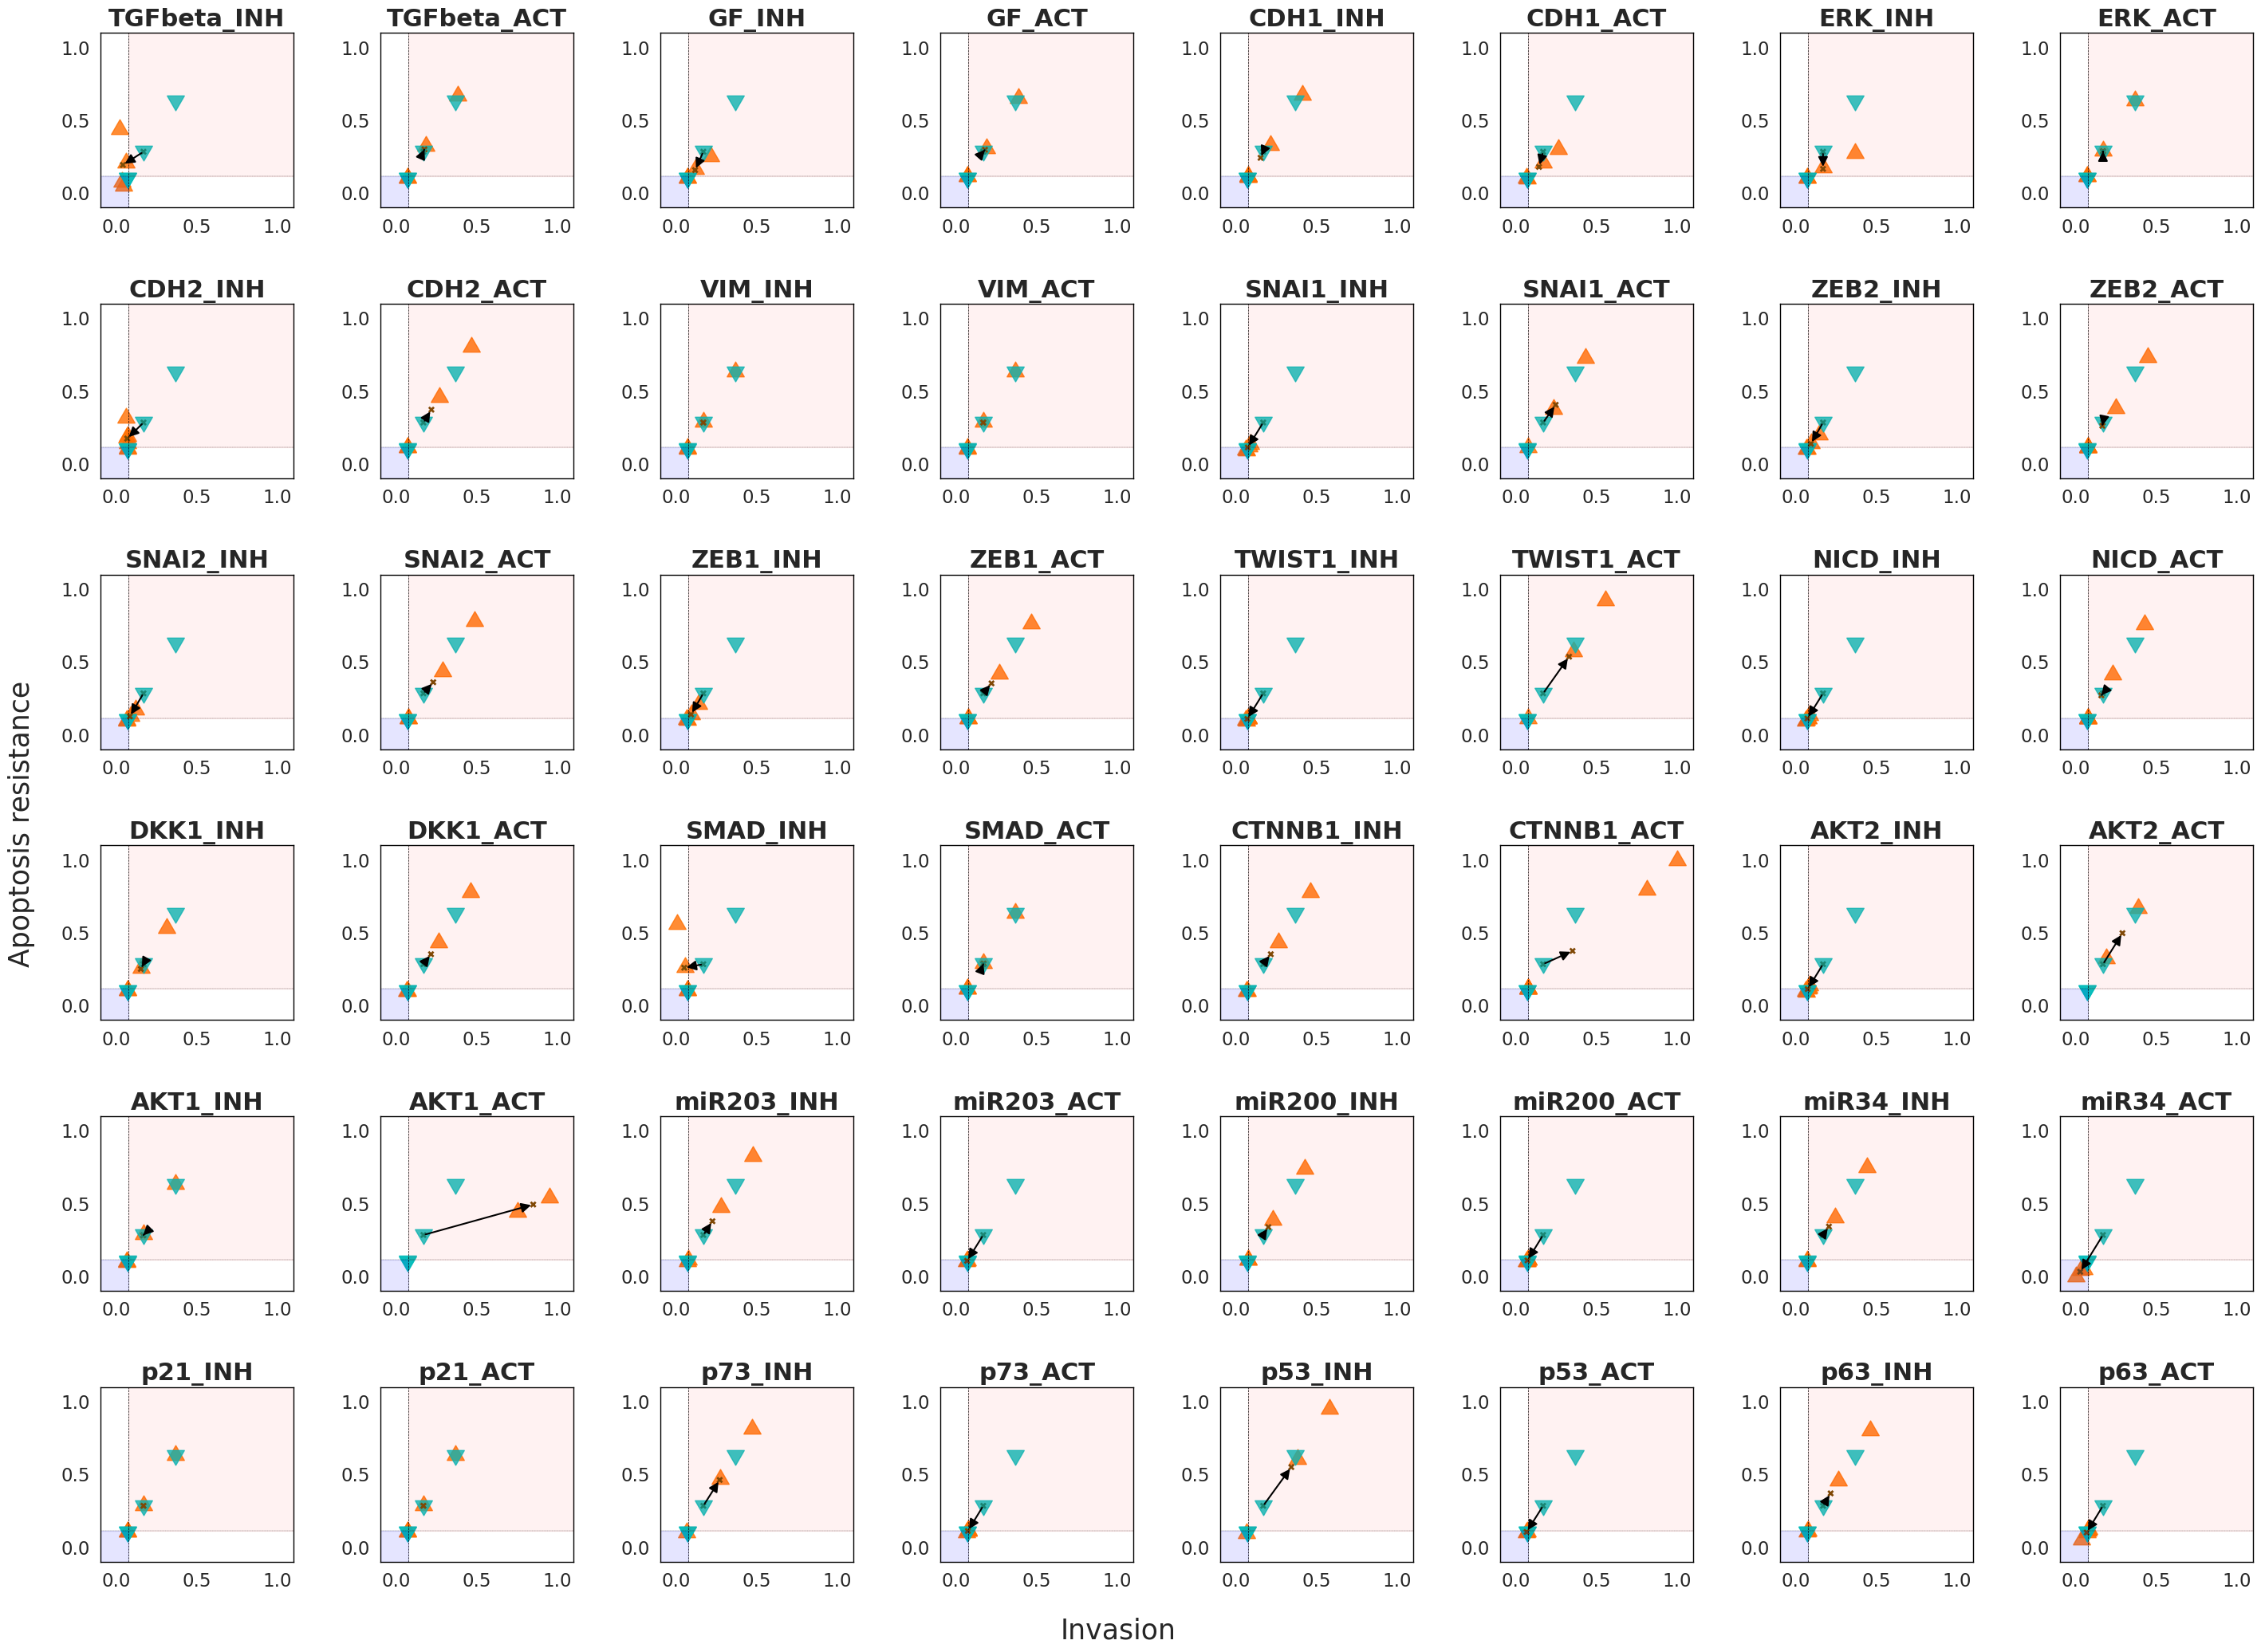

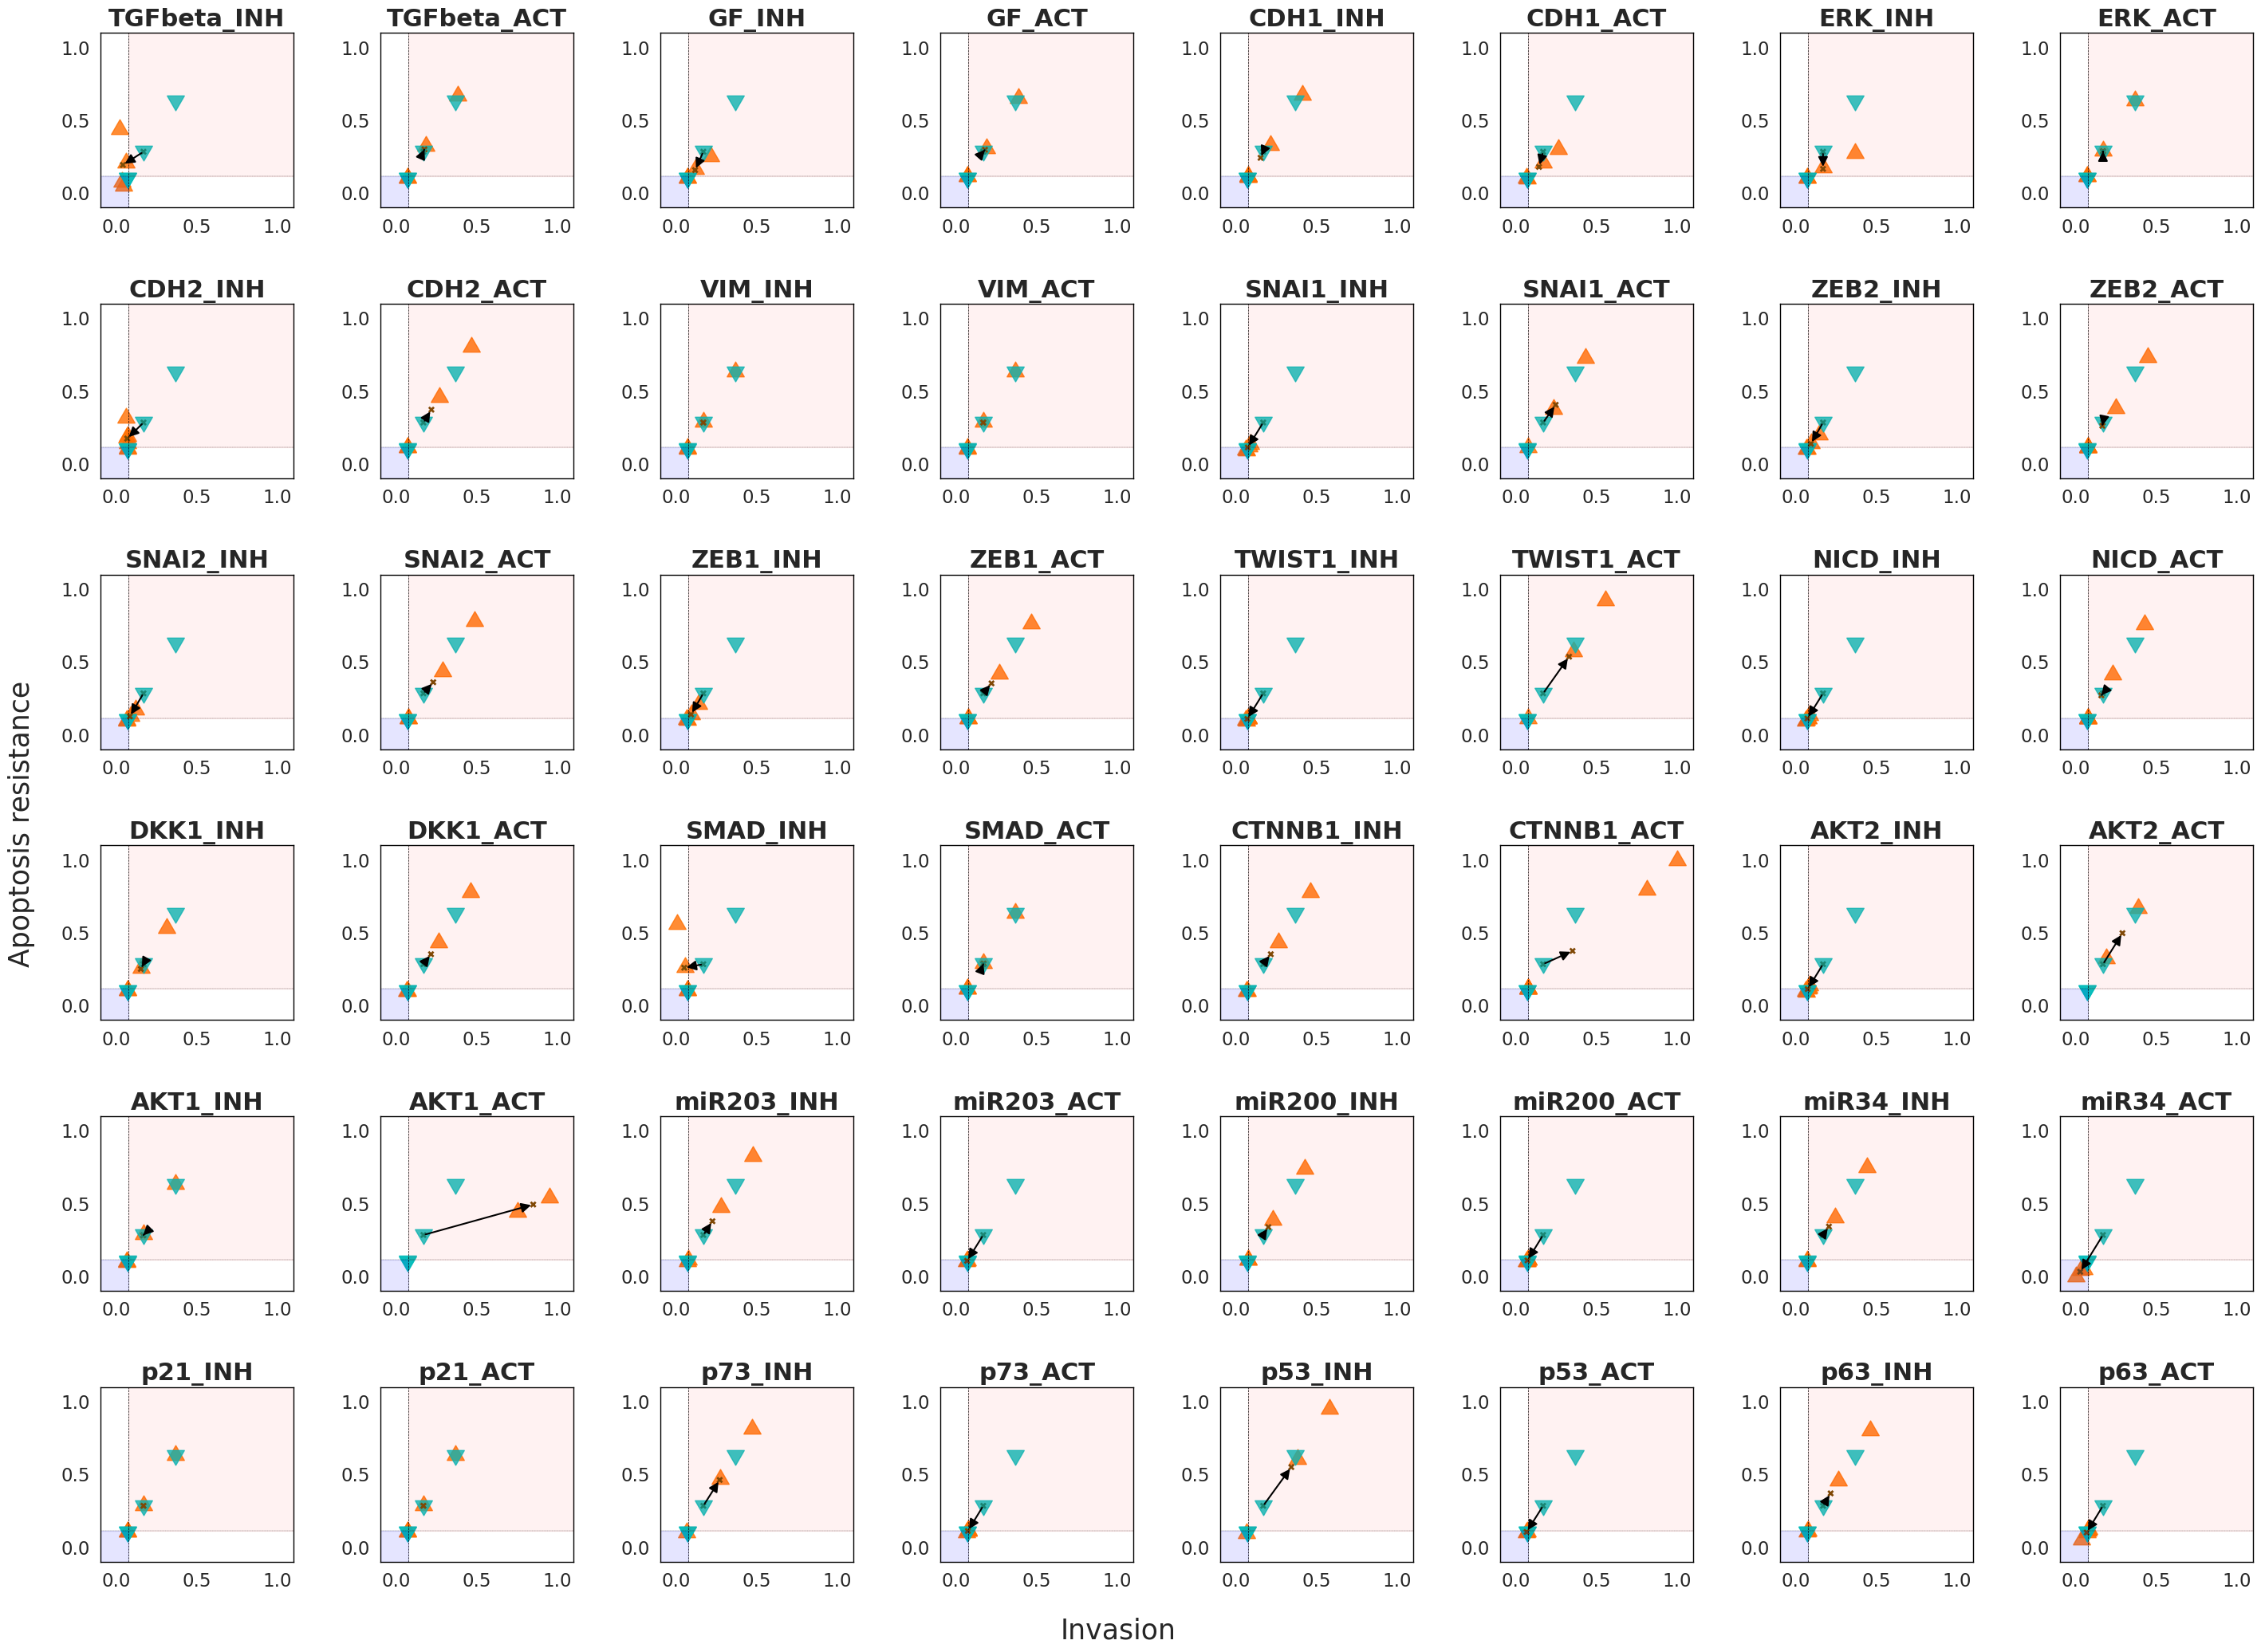

In [76]:
plotTransition(SSwise_res, n_rows = 6, n_cols = 8, x0 = zero_equiv_invasion, y0 = zero_equiv_apop_resistance, onlyprolif = False, save = "Figures/png/Figure_S5.png"); plotTransition(SSwise_res, n_rows = 6, n_cols = 8, x0 = zero_equiv_invasion, y0 = zero_equiv_apop_resistance, onlyprolif = False, save = "Figures/pdf/Figure_S5.pdf")

<p>
    <b>Supplementary Figure S5: </b>Single-perturbation-induced invasiveness fate transitions represented by the scaled path counts upon every perturbation performed. Each plot corresponds to a specific perturbation. The x-axis represents SS-wise min-max scaled path counts for the Invasion node, and the y-axis shows apoptosis resistance as 1 - the SS-wise min-max scaled path counts for the Apoptosis node. Blue and brown triangles indicate the SS of the unperturbed and perturbed models, respectively.  Since the model has one input node allowed to vary between 1 or 0, and two stable states in either condition, there are four blue triangles (two superimposed and not visible in the figure). Blue and brown crosses represent the averaged SS path counts for the unperturbed and perturbed models, respectively. Black arrows illustrate the transitions in invasive fate from the unperturbed to the perturbed setups. Dashed horizontal and vertical lines separate sectors with negative and positive path counts (i.e. inactive and active states) for the Invasion and Apoptosis nodes, respectively. Red and blue areas display pro-invasive (i.e. Invasion = 1, Apoptosis = 0) and pro-apoptotic (i.e. Invasion = 0, Apoptosis = 1). 
</p>

In [74]:
def plotTransition(data, n_rows, n_cols, x0, y0, onlyprolif = False, save = False, width = 29, heigh = 21): # Data must include the following: 
    perts = data["Perturbation"].unique()
    perts = [pert for pert in perts if pert != "Unperturbed"]
    if onlyprolif: unpert_SS = data.loc[(data["Perturbation"] == "Unperturbed") & (data["ls_apoptosis"] == 0), :]
    else: unpert_SS = data.loc[data["Perturbation"] == "Unperturbed", :]
    fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = (width, heigh))
    pert_idx = 0
    for i in range(n_rows):
        for j in range(n_cols):
            if pert_idx < len(perts):
                ax = axes[i, j]
                pert = perts[pert_idx]
                pert_SS = data.loc[data["Perturbation"] == pert, :]
                combined = pd.concat([unpert_SS, pert_SS])
                combined_means = combined.groupby("Perturbation").mean()
                ax.scatter(
                    x = combined.loc[combined["Perturbation"] == pert, "paths_invasion_sc"], 
                    y = combined.loc[combined["Perturbation"] == pert, "paths_apop_resistance_sc"], 
                    marker = (3, 0, 0), s = 320, c = "#ff7001", alpha = 0.8
                )
                ax.scatter(
                    x = combined.loc[combined["Perturbation"] == "Unperturbed", "paths_invasion_sc"], 
                    y = combined.loc[combined["Perturbation"] == "Unperturbed", "paths_apop_resistance_sc"], 
                    marker = (3, 0, 60), s = 320, c = "#01bcba", alpha = 0.8
                )
                sb.scatterplot(
                    x = "paths_invasion_sc", y = "paths_apop_resistance_sc", data = combined_means, hue = "Perturbation", palette = {"Unperturbed": "#0e8d79", pert: "#7a4c06"}, alpha = 1, marker = "x", s = 20, ax = ax, legend = False, linewidth = 2
                )
                ax.annotate(
                    "",
                    xy = (combined_means.at[pert, "paths_invasion_sc"], combined_means.at[pert, "paths_apop_resistance_sc"]),
                    xytext = (combined_means.at["Unperturbed", "paths_invasion_sc"], combined_means.at["Unperturbed", "paths_apop_resistance_sc"]),
                    arrowprops = dict(arrowstyle = "-|>", color = "black", lw = 1.5, alpha = 1)
                )
                for spine in ax.spines.values():
                    spine.set_edgecolor("black")
                    spine.set_linewidth(1)
                ax.set_facecolor("white")
                ax.axhline(y = y0, color = "black", linestyle = "--", linewidth = 0.2); ax.axvline(x = x0, color = "black", linestyle = "--", linewidth = 0.5)
                ax.set_xlim(-0.1, 1.1); ax.set_ylim(-0.1, 1.1)
                ax.set_title(pert, fontweight = "bold", fontsize = 22)
                ax.set_xlabel(""); ax.set_ylabel("")
                pert_idx += 1
                ax.fill_between([x0, 1.1], y0, 1.1, color="red", alpha=0.05)
                ax.fill_between([ -0.1, x0], -0.1, y0, color="blue", alpha=0.1)
    for plot in range(pert_idx, n_rows*n_cols): # remove empty plots
        axes.flatten()[plot].axis("off")
    fig.supxlabel("Invasion", fontsize=25)
    fig.supylabel("Apoptosis resistance", fontsize=25)
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.55, wspace=0.45)
    fig.subplots_adjust(left=0.06) 
    if save: plt.savefig(save)
    plt.show()  